<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/climate_land_use_gradient_carbon_analaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 126.1 MB/s eta 0:00:00


In [2]:
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load carbon data
carbon = gpd.read_file(
    '/content/carbon_predictions_master_aligned_32604.gpkg',
    layer='carbon_predictions_master_aligned_32604'
)

In [3]:
# Load covariate layers
climate_bins = rasterio.open('/content/climate_bins.tif')
# rangelands = gpd.read_file('/content/rangeland_pastures_subregion.gpkg')
# pineapple = gpd.read_file('/content/pineapple_sugarcane_subregion.gpkg')
suborders = gpd.read_file('/content/clipped_haleakala_suborders.gpkg')
# baseline = gpd.read_file('/content/2015_ag_baseline_subregion.gpkg')
baseline = gpd.read_file('/content/2015_ag_baseline_subregion_landuse.gpkg')

In [5]:
rpath = "/content/T_max_ann_subregion.tif"

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["tmax_ann_mean_30m"] = [
    zs["mean"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["mean"],
        nodata=None,
        all_touched=True
    )
]


In [6]:
rpath = "/content/rainfall_ann_mm_subregion.tif"

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["rainfall_ann_mm_30m"] = [
    zs["mean"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["mean"],
        nodata=None,
        all_touched=True
    )
]



In [7]:
rpath = '/content/climate_bins.tif'

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["climate_bin"] = [
    zs["majority"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["majority"],
        nodata=None,
        all_touched=True
    )
]



In [8]:
# Add climate bin descriptions
bin_descriptions = {
    1: "Cool/All rainfall",
    10: "Moderate/Dry-Mod",
    11: "Moderate/Wet",
    20: "Warm/Dry",
    21: "Warm/Mod-Wet"
}
baseline['climate_description'] = baseline['climate_bin'].map(bin_descriptions)


In [9]:
baseline['poly_id'] = range(len(baseline))

In [10]:
# Get all the monthly carbon columns
date_cols = [col for col in carbon.columns if col.startswith('d_')]
print(f"Found {len(date_cols)} monthly predictions")
print(f"Date range: {date_cols[0]} to {date_cols[-1]}")

# Extract year from column names to identify first and last year
def get_year(col):
    date_str = col.split('_')[1]
    return int(date_str[:4])

# Get unique years
years = sorted(set([get_year(col) for col in date_cols]))
first_year = years[0]
last_year = years[-1]

print(f"First year: {first_year}")
print(f"Last year: {last_year}")

# Get columns for first and last year
first_year_cols = [col for col in date_cols if get_year(col) == first_year]
last_year_cols = [col for col in date_cols if get_year(col) == last_year]

print(f"First year columns ({first_year}): {len(first_year_cols)} months")
print(f"Last year columns ({last_year}): {len(last_year_cols)} months")

# Calculate mean carbon across all months
carbon['carbon_mean'] = carbon[date_cols].mean(axis=1)
carbon['carbon_median'] = carbon[date_cols].median(axis=1)
carbon['carbon_std'] = carbon[date_cols].std(axis=1)
carbon['carbon_min'] = carbon[date_cols].min(axis=1)
carbon['carbon_max'] = carbon[date_cols].max(axis=1)

# Add first and last year averages
carbon['carbon_first_year'] = carbon[first_year_cols].mean(axis=1)
carbon['carbon_last_year'] = carbon[last_year_cols].mean(axis=1)

# Calculate change over time
carbon['carbon_change'] = carbon['carbon_last_year'] - carbon['carbon_first_year']
carbon['carbon_pct_change'] = ((carbon['carbon_last_year'] - carbon['carbon_first_year']) / carbon['carbon_first_year']) * 100

# Use the temporal mean for summaries
carbon_col = 'carbon_mean'

print(f"\nCarbon statistics:")
print(f"  Overall mean: {carbon['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {carbon['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {carbon['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {carbon['carbon_change'].mean():.2f}% ({carbon['carbon_pct_change'].mean():.2f}% change)")

Found 98 monthly predictions
Date range: d_20161217 to d_20241205
First year: 2016
Last year: 2024
First year columns (2016): 1 months
Last year columns (2024): 12 months

Carbon statistics:
  Overall mean: 4.07%
  First year (2016) mean: 4.38%
  Last year (2024) mean: 3.59%
  Average change: -0.57% (-14.77% change)


In [11]:
carbon_landuse = gpd.sjoin(carbon, baseline, how='inner', predicate='intersects')

In [49]:
# carbon_landuse = gpd.sjoin(carbon_landuse, suborders, how='inner', predicate='intersects')

In [12]:
[i for i in carbon_landuse.columns]

['id',
 'lat',
 'lon',
 'lat_lon_id',
 'landsat_9_unique_locs_id',
 'landsat_9_unique_locs_min_dis',
 'landsat_8_unique_locs_id',
 'landsat_8_unique_locs_min_dis',
 'landsat_7_unique_locs_id',
 'landsat_7_unique_locs_min_dis',
 'landsat_5_unique_locs_id',
 'landsat_5_unique_locs_min_dis',
 'terrain_SRTM_unique_locs_id',
 'terrain_SRTM_unique_locs_min_dis',
 'terrain_aspect_unique_locs_id',
 'terrain_aspect_unique_locs_min_dis',
 'terraclimate_unique_locs_id',
 'terraclimate_unique_locs_min_dis',
 'terrain_elevation_unique_locs_id',
 'terrain_elevation_unique_locs_min_dis',
 'terrain_slope_unique_locs_id',
 'terrain_slope_unique_locs_min_dis',
 'd_20161217',
 'd_20170116',
 'd_20170215',
 'd_20170317',
 'd_20170416',
 'd_20170516',
 'd_20170615',
 'd_20170715',
 'd_20170814',
 'd_20170913',
 'd_20171013',
 'd_20171112',
 'd_20171212',
 'd_20180111',
 'd_20180210',
 'd_20180312',
 'd_20180411',
 'd_20180511',
 'd_20180610',
 'd_20180710',
 'd_20180809',
 'd_20180908',
 'd_20181008',
 'd_

In [13]:
# Define which columns are categorical vs numeric
categorical_cols = ['CropCatego', 'Island', 'landuse_historic', 'landuse_current',
                   'climate_bin_right', 'climate_description']

numeric_cols = ['carbon_mean', 'carbon_median', 'carbon_std', 'carbon_min', 'carbon_max',
                'climate_bin_left', 'carbon_first_year', 'carbon_last_year',
                'carbon_change', 'carbon_pct_change', 'tmax_ann_mean_30m',
                'rainfall_ann_mm_30m']

# Build aggregation dictionary
agg_dict = {}

# Numeric columns - calculate mean
for col in numeric_cols:
    if col in carbon_landuse.columns:
        agg_dict[col] = 'mean'

# Categorical columns - take mode (most frequent value)
for col in categorical_cols:
    if col in carbon_landuse.columns:
        agg_dict[col] = lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]

# Group by polygon
polygon_summary = carbon_landuse.groupby('poly_id').agg(agg_dict).reset_index()

# Add point count separately
point_counts = carbon_landuse.groupby('poly_id').size().reset_index(name='n_points')
polygon_summary = polygon_summary.merge(point_counts, on='poly_id')

print(f"Original: {len(carbon_landuse)} points")
print(f"Aggregated: {len(polygon_summary)} polygons")
print(f"Points per polygon - Min: {polygon_summary['n_points'].min()}, Max: {polygon_summary['n_points'].max()}, Mean: {polygon_summary['n_points'].mean():.1f}")

# Save
polygon_summary.to_csv('carbon_polygon_summary.csv', index=False)
print("\nSaved carbon_polygon_summary.csv")

Original: 274505 points
Aggregated: 264 polygons
Points per polygon - Min: 1, Max: 25004, Mean: 1039.8

Saved carbon_polygon_summary.csv


In [14]:
polygon_summary

,poly_id,carbon_mean,carbon_median,carbon_std,carbon_min,carbon_max,carbon_first_year,carbon_last_year,carbon_change,carbon_pct_change,tmax_ann_mean_30m,rainfall_ann_mm_30m,CropCatego,Island,landuse_historic,landuse_current,climate_description,n_points
0,0,2.691433,2.593245,0.830634,1.170490,4.401161,3.154667,2.082790,-1.076918,-33.670969,28.180918,398.343928,Sugar,Maui,sugarcane,sugarcane,Warm/Dry,2651
1,1,2.689504,2.576325,0.682873,1.302121,4.108402,3.579168,2.211602,-1.376237,-38.243459,28.214982,408.154358,Sugar,Maui,sugarcane,sugarcane,Warm/Dry,1198
2,2,2.174819,2.152651,0.540390,1.059464,3.327043,2.579430,2.250943,-0.328345,-10.904836,28.165777,386.899691,Sugar,Maui,sugarcane,sugarcane,Warm/Dry,1376
3,3,3.591914,3.600662,0.523005,2.424132,4.675045,3.982823,3.196265,-0.786558,-19.331401,27.499537,1076.418094,Sugar,Maui,sugarcane,range,Warm/Mod-Wet,360
4,4,3.399614,3.393993,0.489941,2.343564,4.491794,3.344945,3.059407,-0.285539,-7.504964,26.721913,1315.535042,Sugar,Maui,sugarcane,range,Warm/Mod-Wet,739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,270,4.815159,4.819818,0.557240,3.576715,5.996530,4.634875,4.784839,0.149964,4.063081,26.943327,1468.069250,Pasture,Maui,pineapple,range,Warm/Mod-Wet,125
260,271,5.102197,5.110032,0.539836,3.883607,6.290878,5.290325,4.705334,-0.584991,-10.844552,26.549797,1864.437857,Pasture,Maui,pineapple,range,Warm/Mod-Wet,65
261,272,4.383565,4.354043,0.579018,3.118557,5.688590,4.067069,4.242504,0.175434,4.467498,26.617931,1791.139500,Pasture,Maui,pineapple,range,Warm/Mod-Wet,34
262,273,5.001880,4.998891,0.566125,3.795556,6.234128,5.315177,4.623939,-0.691238,-12.802324,26.328283,1993.852700,Pasture,Maui,pineapple,range,Warm/Mod-Wet,493


In [16]:
from scipy import stats

# Create transition column
polygon_summary['transition'] = (polygon_summary['landuse_historic'].astype(str) +
                                 ' → ' +
                                 polygon_summary['landuse_current'].astype(str))

# Filter for pineapple transitions
pineapple_stable = polygon_summary[polygon_summary['transition'] == 'pineapple → pineapple']['carbon_mean']
pineapple_to_range = polygon_summary[polygon_summary['transition'] == 'pineapple → range']['carbon_mean']

# Filter for sugarcane transitions
sugar_stable = polygon_summary[polygon_summary['transition'] == 'sugarcane → sugarcane']['carbon_mean']
sugar_to_range = polygon_summary[polygon_summary['transition'] == 'sugarcane → range']['carbon_mean']

print("="*80)
print("PINEAPPLE COMPARISONS")
print("="*80)

# Pineapple: stable vs to range
if len(pineapple_stable) > 0 and len(pineapple_to_range) > 0:
    print(f"\npineapple → pineapple: n={len(pineapple_stable)}, mean={pineapple_stable.mean():.2f}%, std={pineapple_stable.std():.2f}%")
    print(f"pineapple → range: n={len(pineapple_to_range)}, mean={pineapple_to_range.mean():.2f}%, std={pineapple_to_range.std():.2f}%")

    t_stat, p_value = stats.ttest_ind(pineapple_stable, pineapple_to_range)
    print(f"\nT-test: pineapple → pineapple vs pineapple → range")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"  Mean difference: {pineapple_stable.mean() - pineapple_to_range.mean():.2f}%")
else:
    print("Insufficient data for pineapple comparison")
    print(f"  pineapple → pineapple: n={len(pineapple_stable)}")
    print(f"  pineapple → range: n={len(pineapple_to_range)}")

print("\n" + "="*80)
print("SUGARCANE COMPARISONS")
print("="*80)

# Sugar: stable vs to range
if len(sugar_stable) > 0 and len(sugar_to_range) > 0:
    print(f"\nsugarcane → sugarcane: n={len(sugar_stable)}, mean={sugar_stable.mean():.2f}%, std={sugar_stable.std():.2f}%")
    print(f"sugarcane → range: n={len(sugar_to_range)}, mean={sugar_to_range.mean():.2f}%, std={sugar_to_range.std():.2f}%")

    t_stat, p_value = stats.ttest_ind(sugar_stable, sugar_to_range)
    print(f"\nT-test: sugarcane → sugarcane vs sugarcane → range")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"  Mean difference: {sugar_stable.mean() - sugar_to_range.mean():.2f}%")
else:
    print("Insufficient data for sugar comparison")
    print(f"  sugarcane → sugarcane: n={len(sugar_stable)}")
    print(f"  sugarcane → range: n={len(sugar_to_range)}")

# Check what transitions actually exist
print("\n" + "="*80)
print("AVAILABLE TRANSITIONS")
print("="*80)
print("\nAll transitions in dataset:")
print(polygon_summary['transition'].value_counts())

PINEAPPLE COMPARISONS

pineapple → pineapple: n=70, mean=4.65%, std=0.99%
pineapple → range: n=45, mean=4.89%, std=0.75%

T-test: pineapple → pineapple vs pineapple → range
  t-statistic: -1.393
  p-value: 0.1664
  Significant at α=0.05: No
  Mean difference: -0.24%

SUGARCANE COMPARISONS

sugarcane → sugarcane: n=78, mean=2.63%, std=0.56%
sugarcane → range: n=56, mean=3.35%, std=0.58%

T-test: sugarcane → sugarcane vs sugarcane → range
  t-statistic: -7.239
  p-value: 0.0000
  Significant at α=0.05: Yes
  Mean difference: -0.72%

AVAILABLE TRANSITIONS

All transitions in dataset:
transition
sugarcane → sugarcane    78
pineapple → pineapple    70
sugarcane → range        56
pineapple → range        45
range → range            10
None → None               2
forest → range            2
None → range              1
Name: count, dtype: int64


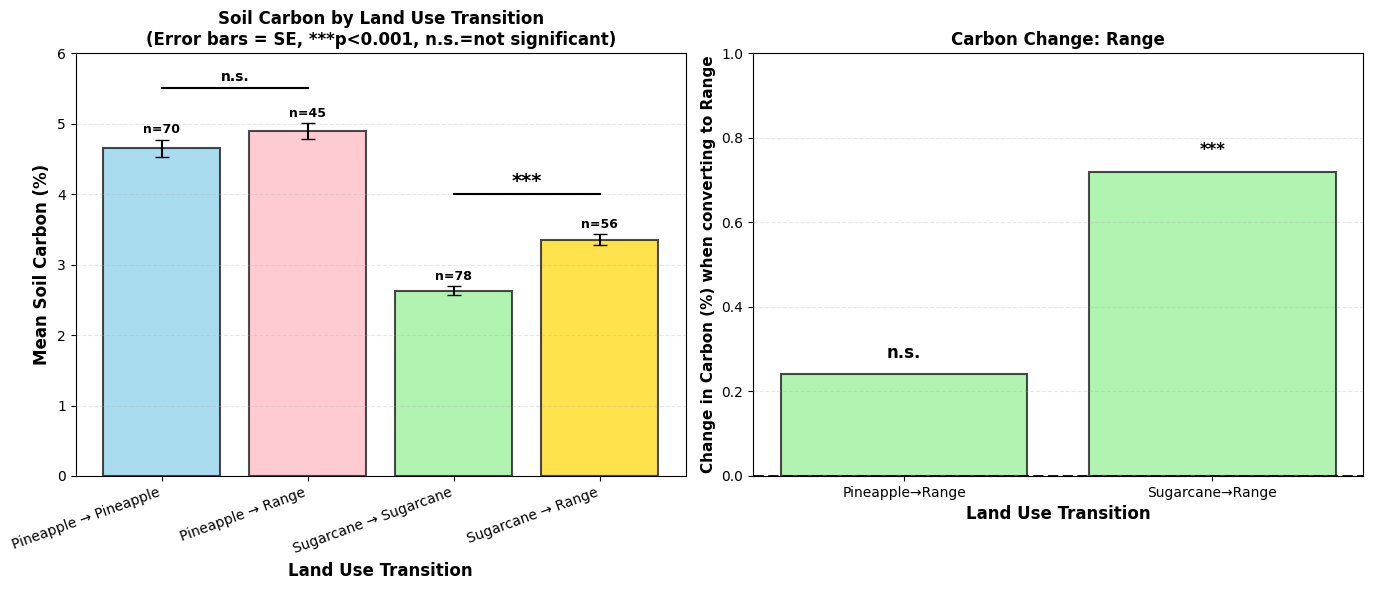


SUMMARY

Pineapple:
  Converting to range: +0.24% carbon (NOT significant, p=0.17)
  Interpretation: No significant difference in carbon between stable pineapple and pineapple→range

Sugarcane:
  Converting to range: +0.72% carbon (HIGHLY significant, p<0.001)
  Interpretation: Sugarcane fields converted to range have 27.4% higher carbon


In [25]:
# Prepare data for plotting
categories = ['Pineapple → Pineapple', 'Pineapple → Range',
              'Sugarcane → Sugarcane', 'Sugarcane → Range']

means = [4.65, 4.89, 2.63, 3.35]
stds = [0.99, 0.75, 0.56, 0.58]
ns = [70, 45, 78, 56]

# Calculate standard errors
ses = [stds[i] / np.sqrt(ns[i]) for i in range(len(stds))]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LEFT PLOT: Bar plot with error bars (unchanged)
colors = ['#87CEEB', '#FFB6C1', '#90EE90', '#FFD700']
x_pos = np.arange(len(categories))

bars = axes[0].bar(x_pos, means, yerr=ses, capsize=5, alpha=0.7,
                   color=colors, edgecolor='black', linewidth=1.5)

# Add sample sizes on bars
for i, (bar, n) in enumerate(zip(bars, ns)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + ses[i] + 0.05,
                f'n={n}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add significance brackets
# Pineapple comparison (not significant)
axes[0].plot([0, 1], [5.5, 5.5], 'k-', linewidth=1.5)
axes[0].text(0.5, 5.6, 'n.s.', ha='center', fontsize=10, fontweight='bold')

# Sugarcane comparison (significant)
axes[0].plot([2, 3], [4.0, 4.0], 'k-', linewidth=1.5)
axes[0].text(2.5, 4.1, '***', ha='center', fontsize=14, fontweight='bold')

axes[0].set_ylabel('Mean Soil Carbon (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
axes[0].set_title('Soil Carbon by Land Use Transition\n(Error bars = SE, ***p<0.001, n.s.=not significant)',
                  fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories, rotation=20, ha='right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, 6)

# RIGHT PLOT: Difference plot showing change
differences = [means[1] - means[0], means[3] - means[2]]
diff_labels = ['Pineapple→Range', 'Sugarcane→Range']
diff_colors = ['#FF6B6B' if d < 0 else '#90EE90' for d in differences]
sig_markers = ['n.s.', '***']

x_pos2 = np.arange(len(differences))
bars2 = axes[1].bar(x_pos2, differences, alpha=0.7, color=diff_colors,
                    edgecolor='black', linewidth=1.5)

# Add zero line
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

# Add significance markers with adjusted positioning
for i, (bar, sig) in enumerate(zip(bars2, sig_markers)):
    height = bar.get_height()
    y_pos = height + 0.03 if height > 0 else height - 0.03  # Reduced offset
    va = 'bottom' if height > 0 else 'top'
    axes[1].text(bar.get_x() + bar.get_width()/2., y_pos, sig,
                ha='center', va=va, fontweight='bold', fontsize=12)

axes[1].set_ylabel('Change in Carbon (%) when converting to Range', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
axes[1].set_title('Carbon Change: Range',
                  fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos2)
axes[1].set_xticklabels(diff_labels)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, 1.0)  # Extended y-axis to fit stars

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print("\nPineapple:")
print(f"  Converting to range: +{means[1] - means[0]:.2f}% carbon (NOT significant, p=0.17)")
print(f"  Interpretation: No significant difference in carbon between stable pineapple and pineapple→range")

print("\nSugarcane:")
print(f"  Converting to range: +{means[3] - means[2]:.2f}% carbon (HIGHLY significant, p<0.001)")
print(f"  Interpretation: Sugarcane fields converted to range have {((means[3]/means[2])-1)*100:.1f}% higher carbon")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. SUMMARY STATISTICS
print("="*80)
print("CLIMATE SUMMARY STATISTICS")
print("="*80)
print(f"\nTemperature (tmax_ann_mean_30m):")
print(f"  Mean: {polygon_summary['tmax_ann_mean_30m'].mean():.2f}°C")
print(f"  Std: {polygon_summary['tmax_ann_mean_30m'].std():.2f}°C")
print(f"  Range: {polygon_summary['tmax_ann_mean_30m'].min():.2f} - {polygon_summary['tmax_ann_mean_30m'].max():.2f}°C")

print(f"\nRainfall (rainfall_ann_mm_30m):")
print(f"  Mean: {polygon_summary['rainfall_ann_mm_30m'].mean():.2f} mm")
print(f"  Std: {polygon_summary['rainfall_ann_mm_30m'].std():.2f} mm")
print(f"  Range: {polygon_summary['rainfall_ann_mm_30m'].min():.2f} - {polygon_summary['rainfall_ann_mm_30m'].max():.2f} mm")

# 2. CLIMATE BY LAND USE TYPE
print("\n" + "="*80)
print("CLIMATE BY CURRENT LAND USE")
print("="*80)
climate_by_landuse = polygon_summary.groupby('landuse_current').agg({
    'tmax_ann_mean_30m': ['mean', 'std'],
    'rainfall_ann_mm_30m': ['mean', 'std'],
    'poly_id': 'count'
}).round(2)
climate_by_landuse.columns = ['temp_mean', 'temp_std', 'rain_mean', 'rain_std', 'n_polygons']
print(climate_by_landuse)

# 3. CLIMATE BY TRANSITION TYPE
print("\n" + "="*80)
print("CLIMATE BY LAND USE TRANSITION")
print("="*80)
# Focus on key transitions
key_transitions = ['sugarcane → sugarcane', 'sugarcane → range',
                   'pineapple → pineapple', 'pineapple → range']
trans_subset = polygon_summary[polygon_summary['transition'].isin(key_transitions)]

climate_by_transition = trans_subset.groupby('transition').agg({
    'tmax_ann_mean_30m': ['mean', 'std'],
    'rainfall_ann_mm_30m': ['mean', 'std'],
    'poly_id': 'count'
}).round(2)
climate_by_transition.columns = ['temp_mean', 'temp_std', 'rain_mean', 'rain_std', 'n_polygons']
print(climate_by_transition)



CLIMATE SUMMARY STATISTICS

Temperature (tmax_ann_mean_30m):
  Mean: 26.08°C
  Std: 1.96°C
  Range: 16.19 - 28.26°C

Rainfall (rainfall_ann_mm_30m):
  Mean: 866.55 mm
  Std: 542.67 mm
  Range: 349.12 - 2721.22 mm

CLIMATE BY CURRENT LAND USE
                 temp_mean  temp_std  rain_mean  rain_std  n_polygons
landuse_current                                                      
pineapple            24.69      1.28     755.66    335.52          70
range                25.79      2.08    1136.22    618.98         114
sugarcane            27.81      0.43     528.88    187.31          78

CLIMATE BY LAND USE TRANSITION
                       temp_mean  temp_std  rain_mean  rain_std  n_polygons
transition                                                                 
pineapple → pineapple      24.69      1.28     755.66    335.52          70
pineapple → range          25.22      1.20    1365.71    676.82          45
sugarcane → range          27.18      0.49     849.72    362.99         

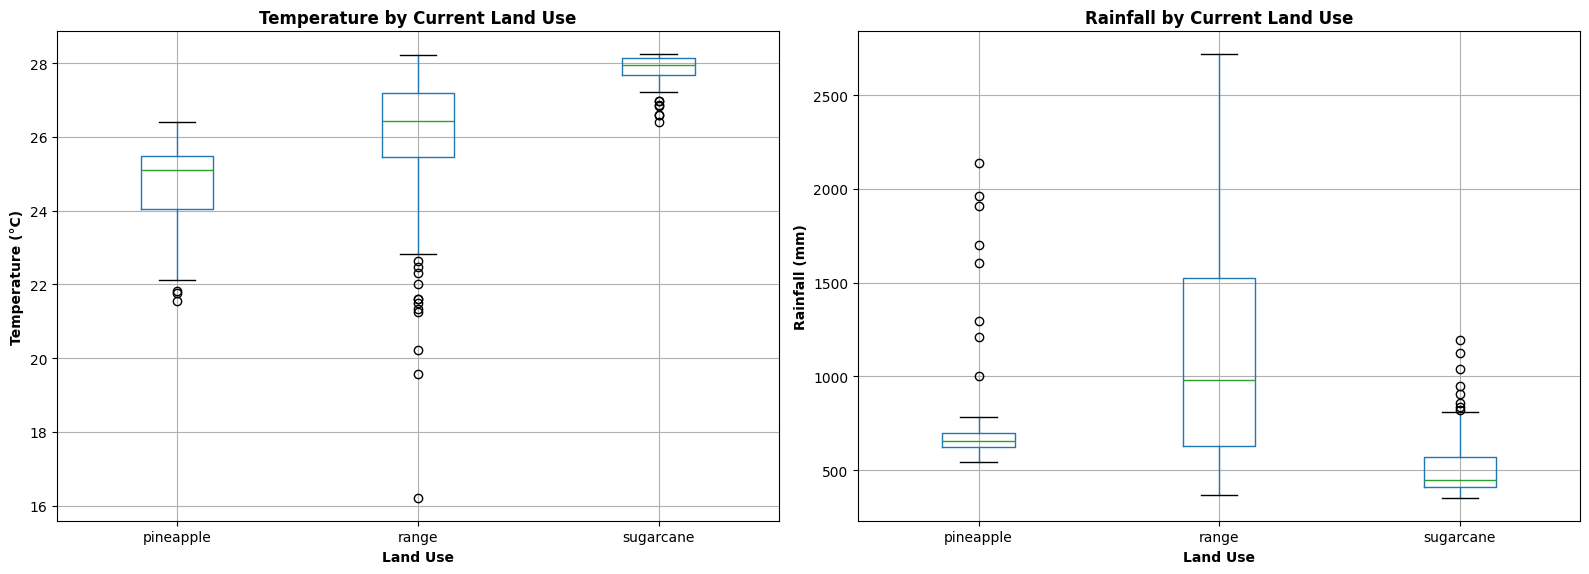

In [34]:
# 4. VISUALIZATIONS
fig = plt.figure(figsize=(16, 6))

# A. Temperature distribution by land use
ax1 = plt.subplot(1, 2, 1)
landuse_order = polygon_summary.groupby('landuse_current')['tmax_ann_mean_30m'].median().sort_values().index
polygon_summary.boxplot(column='tmax_ann_mean_30m', by='landuse_current', ax=ax1)
ax1.set_xlabel('Land Use', fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontweight='bold')
ax1.set_title('Temperature by Current Land Use', fontweight='bold')
ax1.get_figure().suptitle('')  # Remove the automatic grouped boxplot title

# B. Rainfall distribution by land use
ax2 = plt.subplot(1, 2, 2)
polygon_summary.boxplot(column='rainfall_ann_mm_30m', by='landuse_current', ax=ax2)
ax2.set_xlabel('Land Use', fontweight='bold')
ax2.set_ylabel('Rainfall (mm)', fontweight='bold')
ax2.set_title('Rainfall by Current Land Use', fontweight='bold')
ax2.get_figure().suptitle('')  # Remove the automatic grouped boxplot title

plt.tight_layout()
plt.show()


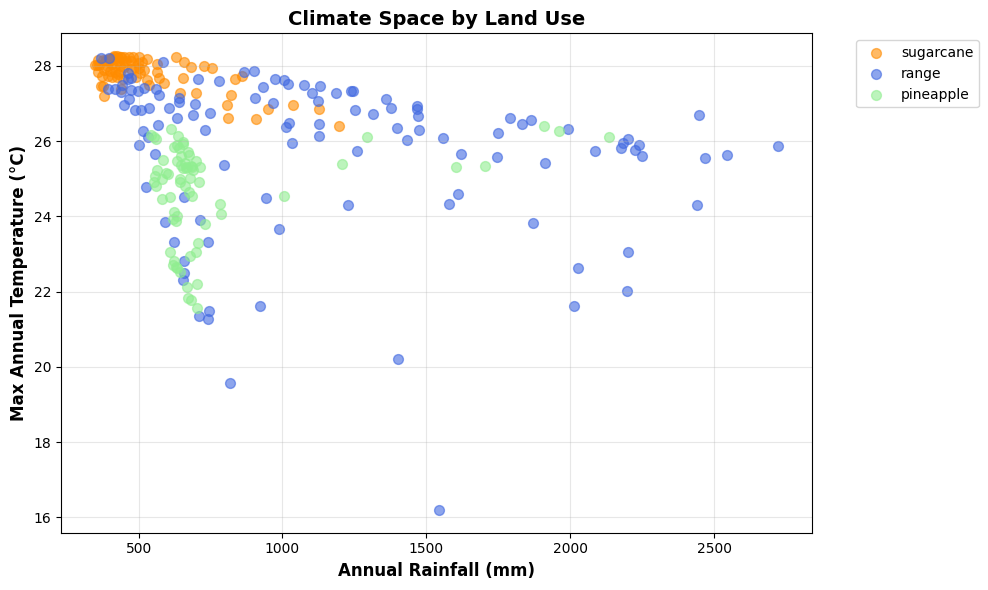

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each land use
color_map = {
    'sugarcane': '#FF8C00',
    'pineapple': '#90EE90',
    'range': '#4169E1'
}

for landuse in polygon_summary['landuse_current'].dropna().unique():
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    color = color_map.get(landuse, 'gray')  # Use gray as default for other land uses
    ax.scatter(subset['rainfall_ann_mm_30m'], subset['tmax_ann_mean_30m'],
               label=landuse, alpha=0.6, s=50, color=color)

ax.set_xlabel('Annual Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Max Annual Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Climate Space by Land Use', fontweight='bold', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

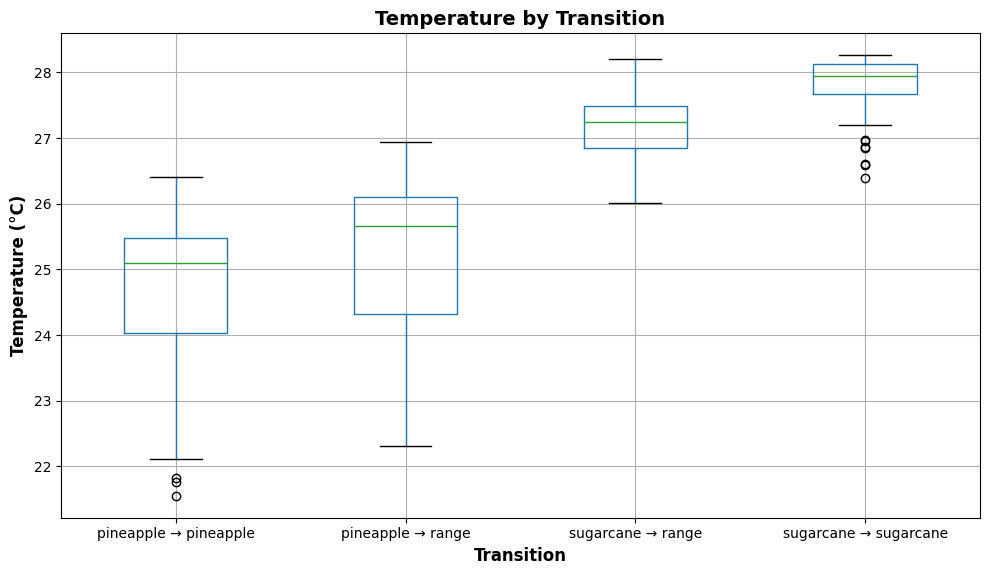

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

trans_subset.boxplot(column='tmax_ann_mean_30m', by='transition', ax=ax)
ax.set_xlabel('Transition', fontweight='bold', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Temperature by Transition', fontweight='bold', fontsize=14)
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

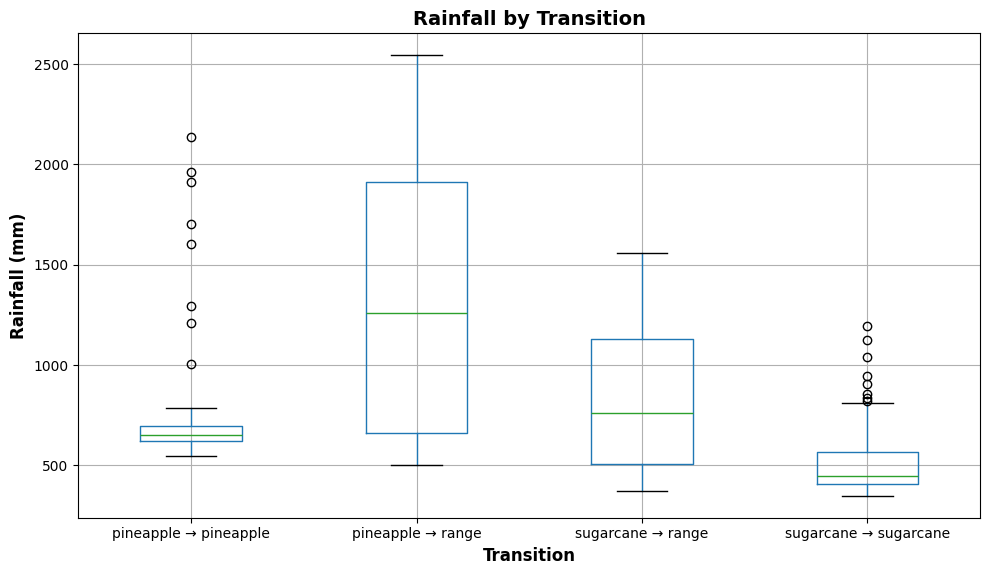

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

trans_subset.boxplot(column='rainfall_ann_mm_30m', by='transition', ax=ax)
ax.set_xlabel('Transition', fontweight='bold', fontsize=12)
ax.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_title('Rainfall by Transition', fontweight='bold', fontsize=14)
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

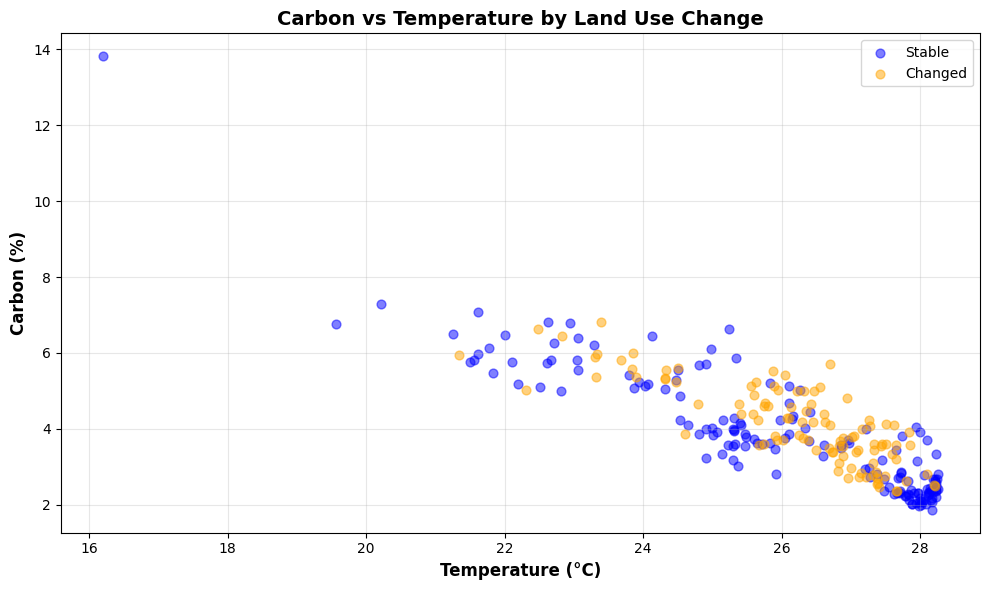

In [45]:
# Create land_use_changed column
polygon_summary['land_use_changed'] = polygon_summary['landuse_historic'] != polygon_summary['landuse_current']

# Now create the plot
fig, ax = plt.subplots(figsize=(10, 6))

changed = polygon_summary[polygon_summary['land_use_changed']]
stable = polygon_summary[~polygon_summary['land_use_changed']]

ax.scatter(stable['tmax_ann_mean_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax.scatter(changed['tmax_ann_mean_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

ax.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon (%)', fontweight='bold', fontsize=12)
ax.set_title('Carbon vs Temperature by Land Use Change', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

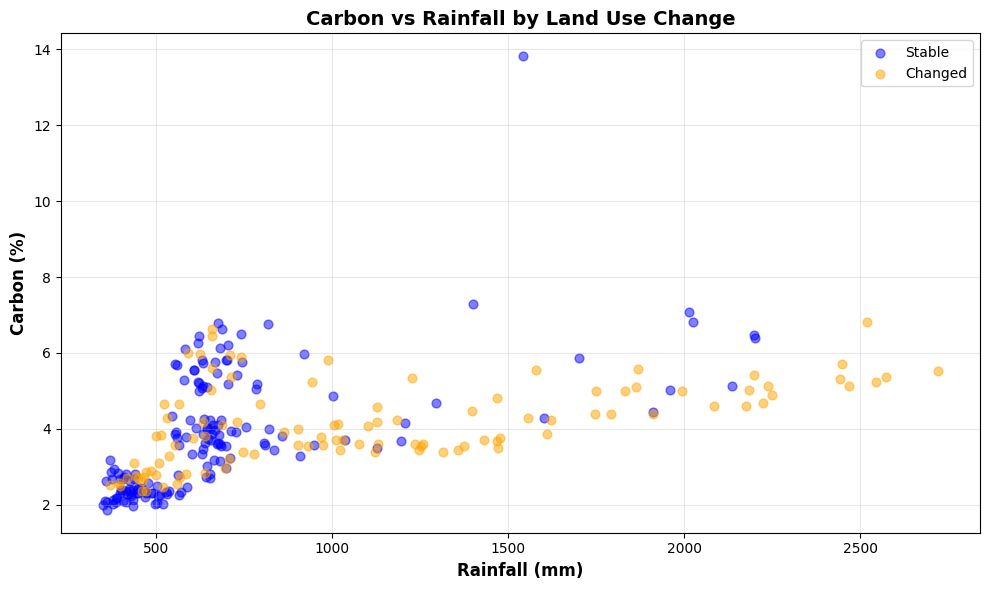

In [47]:
# Now create the plot
fig, ax = plt.subplots(figsize=(10, 6))

changed = polygon_summary[polygon_summary['land_use_changed']]
stable = polygon_summary[~polygon_summary['land_use_changed']]

ax.scatter(stable['rainfall_ann_mm_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax.scatter(changed['rainfall_ann_mm_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

ax.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon (%)', fontweight='bold', fontsize=12)
ax.set_title('Carbon vs Rainfall by Land Use Change', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

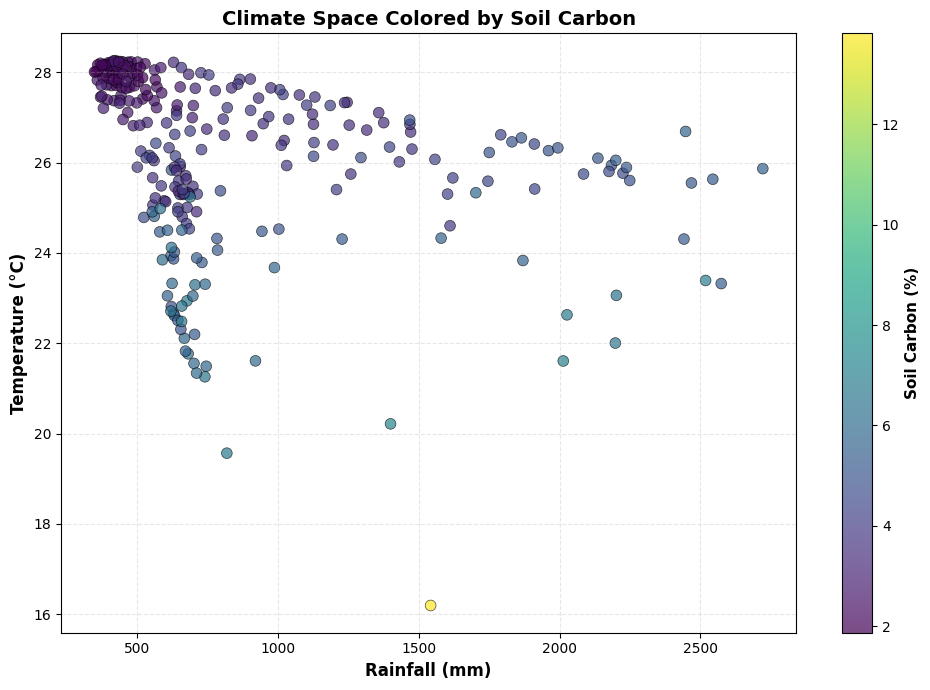

Climate-Carbon relationships:
Warmest & driest:  rainfall_ann_mm_30m  tmax_ann_mean_30m  carbon_mean
          349.123964          28.010157     1.996945
          354.878779          28.012045     2.091985
          359.304316          27.830047     2.627636
          360.459859          28.164342     1.866776
          362.470465          28.032421     2.083135

Coolest & wettest:  rainfall_ann_mm_30m  tmax_ann_mean_30m  carbon_mean
         2721.218082          25.868679     5.520976
         2573.719000          23.322577     5.356785
         2543.830500          25.633612     5.247762
         2518.254000          23.391094     6.817366
         2467.972636          25.550767     5.125450


In [46]:
fig, ax = plt.subplots(figsize=(10, 7))

# Create scatter plot with carbon as color
scatter = ax.scatter(polygon_summary['rainfall_ann_mm_30m'],
                     polygon_summary['tmax_ann_mean_30m'],
                     c=polygon_summary['carbon_mean'],
                     cmap='viridis',  # Color scale
                     s=60,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Soil Carbon (%)')
cbar.set_label('Soil Carbon (%)', fontweight='bold', fontsize=11)

ax.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Climate Space Colored by Soil Carbon', fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Optional: Print some statistics
print("Climate-Carbon relationships:")
print(f"Warmest & driest: {polygon_summary.nsmallest(5, 'rainfall_ann_mm_30m')[['rainfall_ann_mm_30m', 'tmax_ann_mean_30m', 'carbon_mean']].to_string(index=False)}")
print(f"\nCoolest & wettest: {polygon_summary.nlargest(5, 'rainfall_ann_mm_30m')[['rainfall_ann_mm_30m', 'tmax_ann_mean_30m', 'carbon_mean']].to_string(index=False)}")

In [48]:
# 5. CORRELATION ANALYSIS
print("\n" + "="*80)
print("CORRELATION: CARBON WITH CLIMATE VARIABLES")
print("="*80)
print(f"Carbon vs Temperature: r = {polygon_summary[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"Carbon vs Rainfall: r = {polygon_summary[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")

# By stable vs changed
print("\nStable polygons:")
print(f"  Carbon vs Temperature: r = {stable[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"  Carbon vs Rainfall: r = {stable[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")

print("\nChanged polygons:")
print(f"  Carbon vs Temperature: r = {changed[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"  Carbon vs Rainfall: r = {changed[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")


CORRELATION: CARBON WITH CLIMATE VARIABLES
Carbon vs Temperature: r = -0.872
Carbon vs Rainfall: r = 0.494

Stable polygons:
  Carbon vs Temperature: r = -0.903
  Carbon vs Rainfall: r = 0.572

Changed polygons:
  Carbon vs Temperature: r = -0.813
  Carbon vs Rainfall: r = 0.528


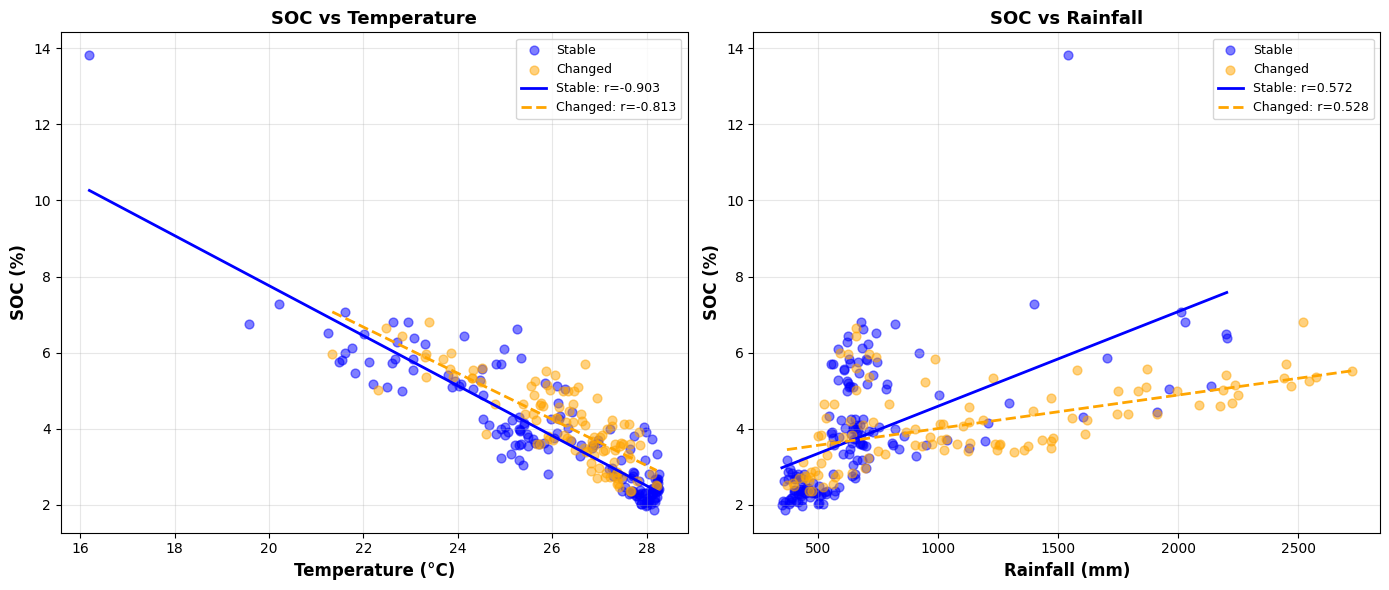


REGRESSION STATISTICS

Temperature:
  Stable:  slope=-0.6572, r=-0.903, p=5.3365e-59
  Changed: slope=-0.6064, r=-0.813, p=4.0114e-26

Rainfall:
  Stable:  slope=0.002485, r=0.572, p=4.3558e-15
  Changed: slope=0.000880, r=0.528, p=6.0131e-09


In [52]:
from scipy import stats
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Carbon vs Temperature with regression lines
ax1 = axes[0]
ax1.scatter(stable['tmax_ann_mean_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax1.scatter(changed['tmax_ann_mean_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

# Add regression lines
# For stable
slope_s, intercept_s, r_s, p_s, se_s = stats.linregress(stable['tmax_ann_mean_30m'].dropna(),
                                                          stable['carbon_mean'].dropna())
x_stable = np.array([stable['tmax_ann_mean_30m'].min(), stable['tmax_ann_mean_30m'].max()])
ax1.plot(x_stable, slope_s * x_stable + intercept_s, 'b-', linewidth=2,
         label=f'Stable: r={r_s:.3f}')

# For changed
slope_c, intercept_c, r_c, p_c, se_c = stats.linregress(changed['tmax_ann_mean_30m'].dropna(),
                                                          changed['carbon_mean'].dropna())
x_changed = np.array([changed['tmax_ann_mean_30m'].min(), changed['tmax_ann_mean_30m'].max()])
ax1.plot(x_changed, slope_c * x_changed + intercept_c, 'orange', linewidth=2, linestyle='--',
         label=f'Changed: r={r_c:.3f}')

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('SOC (%)', fontweight='bold', fontsize=12)
ax1.set_title('SOC vs Temperature', fontweight='bold', fontsize=13)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# RIGHT: Carbon vs Rainfall with regression lines
ax2 = axes[1]
ax2.scatter(stable['rainfall_ann_mm_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax2.scatter(changed['rainfall_ann_mm_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

# For stable
slope_s2, intercept_s2, r_s2, p_s2, se_s2 = stats.linregress(stable['rainfall_ann_mm_30m'].dropna(),
                                                               stable['carbon_mean'].dropna())
x_stable2 = np.array([stable['rainfall_ann_mm_30m'].min(), stable['rainfall_ann_mm_30m'].max()])
ax2.plot(x_stable2, slope_s2 * x_stable2 + intercept_s2, 'b-', linewidth=2,
         label=f'Stable: r={r_s2:.3f}')

# For changed
slope_c2, intercept_c2, r_c2, p_c2, se_c2 = stats.linregress(changed['rainfall_ann_mm_30m'].dropna(),
                                                               changed['carbon_mean'].dropna())
x_changed2 = np.array([changed['rainfall_ann_mm_30m'].min(), changed['rainfall_ann_mm_30m'].max()])
ax2.plot(x_changed2, slope_c2 * x_changed2 + intercept_c2, 'orange', linewidth=2, linestyle='--',
         label=f'Changed: r={r_c2:.3f}')

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('SOC (%)', fontweight='bold', fontsize=12)
ax2.set_title('SOC vs Rainfall', fontweight='bold', fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("REGRESSION STATISTICS")
print("="*80)
print("\nTemperature:")
print(f"  Stable:  slope={slope_s:.4f}, r={r_s:.3f}, p={p_s:.4e}")
print(f"  Changed: slope={slope_c:.4f}, r={r_c:.3f}, p={p_c:.4e}")
print("\nRainfall:")
print(f"  Stable:  slope={slope_s2:.6f}, r={r_s2:.3f}, p={p_s2:.4e}")
print(f"  Changed: slope={slope_c2:.6f}, r={r_c2:.3f}, p={p_c2:.4e}")

In [53]:
suborders

,OBJECTID,MUSYM,MUKEY,CompKey,CompName,TaxClass,SoilOrder,Suborder,GreatGroup,Subgroup,MoistRegim,geometry
0,2187,WeB,468350,468350:650877,Waiakoa,"Fine, kaolinitic, isohyperthermic Torroxic Hap...",Mollisols,Ustolls,Haplustolls,Torroxic Haplustolls,None,"MULTIPOLYGON (((764441.485 2310096.654, 764445..."
1,2189,MfC,468310,468310:650834,Makawao,"Very-fine, parasesquic, isothermic Ustic Paleh...",Ultisols,Humults,Palehumults,Ustic Palehumults,None,"MULTIPOLYGON (((779859.201 2310395.806, 779868..."
2,2191,HhC,468255,468255:650773,Haliimaile,"Very-fine, parasesquic, isothermic Oxic Dystru...",Inceptisols,Ustepts,Dystrustepts,Oxic Dystrustepts,None,"MULTIPOLYGON (((775646.213 2310231.357, 775662..."
3,2193,MfB,468309,468309:650833,Makawao,"Very-fine, parasesquic, isothermic Ustic Paleh...",Ultisols,Humults,Palehumults,Ustic Palehumults,None,"MULTIPOLYGON (((778662.973 2310256.104, 778711..."
4,2194,rRK,468370,468370:650900,Rock land,Lithic Ustorthents,Entisols,Orthents,Ustorthents,Lithic Ustorthents,None,"MULTIPOLYGON (((781277.382 2310236.638, 781309..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1847,41904,HbC,468251,468251:650769,Haiku,"Very-fine, ferritic, isohyperthermic Ustic Pal...",Ultisols,Humults,Palehumults,Ustic Palehumults,None,"MULTIPOLYGON (((778887.04 2315678.172, 778904...."
1848,42438,ONC,468319,468319:650843,Olinda,"Medial, ferrihydritic, isothermic Dystric Hapl...",Andisols,Ustands,Haplustands,Dystric Haplustands,None,"MULTIPOLYGON (((782630.315 2304084.661, 782625..."
1849,42440,KnaC,468288,468288:650810,Keahua,"Fine, kaolinitic, isohyperthermic Ustic Haploc...",Aridisols,Cambids,Haplocambids,Ustic Haplocambids,None,"MULTIPOLYGON (((773750.602 2303661.429, 773758..."
1850,42441,HgB,468252,468252:650770,Haliimaile,"Very-fine, parasesquic, isothermic Oxic Dystru...",Inceptisols,Ustepts,Dystrustepts,Oxic Dystrustepts,None,"MULTIPOLYGON (((778406.049 2304065.705, 778462..."


In [54]:
# Load the soil suborder geopackage
suborders = gpd.read_file('/content/clipped_haleakala_suborders.gpkg')

print(f"Suborders data: {len(suborders)} features")
print(f"Polygon summary: {len(polygon_summary)} polygons")

# Check if polygon_summary is a GeoDataFrame with geometry
if 'geometry' not in polygon_summary.columns:
    print("\nWarning: polygon_summary doesn't have geometry column. Need to get it from original carbon data.")
    # Get one representative point per polygon with its geometry
    polygon_geoms = carbon_landuse.groupby('poly_id').first()[['geometry']].reset_index()
    polygon_summary = polygon_summary.merge(polygon_geoms, on='poly_id', how='left')
    polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry', crs=carbon_landuse.crs)

# Ensure both are GeoDataFrames with same CRS
polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry')
print(f"\nPolygon summary CRS: {polygon_summary.crs}")
print(f"Suborders CRS: {suborders.crs}")

# Reproject if needed
if polygon_summary.crs != suborders.crs:
    polygon_summary = polygon_summary.to_crs(suborders.crs)

# Spatial join to get ALL suborders that intersect each polygon
polygon_soil_join = gpd.sjoin(polygon_summary, suborders[['Suborder', 'geometry']],
                               how='left', predicate='intersects')

# Aggregate suborders into a list per polygon
polygon_suborder_list = polygon_soil_join.groupby('poly_id')['Suborder'].apply(
    lambda x: ', '.join(x.dropna().unique()) if x.notna().any() else None
).reset_index()
polygon_suborder_list.rename(columns={'Suborder': 'Suborder_list'}, inplace=True)

# Add count of suborders
polygon_suborder_count = polygon_soil_join.groupby('poly_id')['Suborder'].nunique().reset_index()
polygon_suborder_count.rename(columns={'Suborder': 'n_suborders'}, inplace=True)

# Merge back to original polygon_summary
polygon_summary = polygon_summary.merge(polygon_suborder_list, on='poly_id', how='left')
polygon_summary = polygon_summary.merge(polygon_suborder_count, on='poly_id', how='left')

print(f"\nResult: {len(polygon_summary)} rows (original size maintained)")
print(f"Polygons with suborder data: {polygon_summary['Suborder_list'].notna().sum()}")
print(f"Polygons with multiple suborders: {(polygon_summary['n_suborders'] > 1).sum()}")

print("\nUnique suborder combinations:")
print(polygon_summary['Suborder_list'].value_counts().head(10))

print("\n✓ Suborder_list and n_suborders columns added to polygon_summary")

Suborders data: 1852 features
Polygon summary: 264 polygons


Polygon summary CRS: PROJCS["WGS 84 / UTM zone 4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32604"]]
Suborders CRS: EPSG:32604

Result: 264 rows (original size maintained)
Polygons with suborder data: 264
Polygons with multiple suborders: 0

Unique suborder combinations:
Suborder_list
Cambids      74
Ustolls      71
Ustands      39
Humults      28
Torrox       20
Ustepts      12
Orthents      8
Andepts       7
Torra

In [55]:
# View the first few rows with the new columns
print("First 10 rows with soil suborder info:")
print(polygon_summary[['poly_id', 'landuse_current', 'carbon_mean',
                       'Suborder_list', 'n_suborders']].head(10))

# View full dataframe info
print("\n" + "="*80)
print("DATAFRAME INFO")
print("="*80)
print(f"Total columns: {len(polygon_summary.columns)}")
print(f"Column names: {polygon_summary.columns.tolist()}")

# Summary statistics by suborder
print("\n" + "="*80)
print("CARBON BY SOIL SUBORDER")
print("="*80)
carbon_by_suborder = polygon_summary.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'min', 'max'],
    'poly_id': 'count'
}).round(2)
carbon_by_suborder.columns = ['carbon_mean', 'carbon_std', 'carbon_min', 'carbon_max', 'n_polygons']
carbon_by_suborder = carbon_by_suborder.sort_values('carbon_mean', ascending=False)
print(carbon_by_suborder)

# View specific rows if interested
print("\n" + "="*80)
print("SAMPLE: Polygons with highest carbon")
print("="*80)
high_carbon = polygon_summary.nlargest(5, 'carbon_mean')[['poly_id', 'carbon_mean',
                                                            'landuse_current', 'Suborder_list',
                                                            'tmax_ann_mean_30m', 'rainfall_ann_mm_30m']]
print(high_carbon.to_string(index=False))

print("\n" + "="*80)
print("SAMPLE: Polygons with lowest carbon")
print("="*80)
low_carbon = polygon_summary.nsmallest(5, 'carbon_mean')[['poly_id', 'carbon_mean',
                                                            'landuse_current', 'Suborder_list',
                                                            'tmax_ann_mean_30m', 'rainfall_ann_mm_30m']]
print(low_carbon.to_string(index=False))

# Save to CSV to view in Excel/other programs
polygon_summary.drop(columns=['geometry']).to_csv('polygon_summary_with_suborder.csv', index=False)
print("\n✓ Saved to polygon_summary_with_suborder.csv")

First 10 rows with soil suborder info:
   poly_id landuse_current  carbon_mean Suborder_list  n_suborders
0        0       sugarcane     2.691433       Ustolls            1
1        1       sugarcane     2.689504       Ustolls            1
2        2       sugarcane     2.174819       Ustolls            1
3        3           range     3.591914       Humults            1
4        4           range     3.399614       Humults            1
5        5           range     4.074589       Ustolls            1
6        6           range     3.564698       Ustolls            1
7        7           range     4.227345       Ustolls            1
8        8           range     3.544773       Ustepts            1
9        9           range     3.498155       Ustepts            1

DATAFRAME INFO
Total columns: 23
Column names: ['poly_id', 'carbon_mean', 'carbon_median', 'carbon_std', 'carbon_min', 'carbon_max', 'carbon_first_year', 'carbon_last_year', 'carbon_change', 'carbon_pct_change', 'tmax_ann_m

/tmp/ipython-input-1674986558.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)


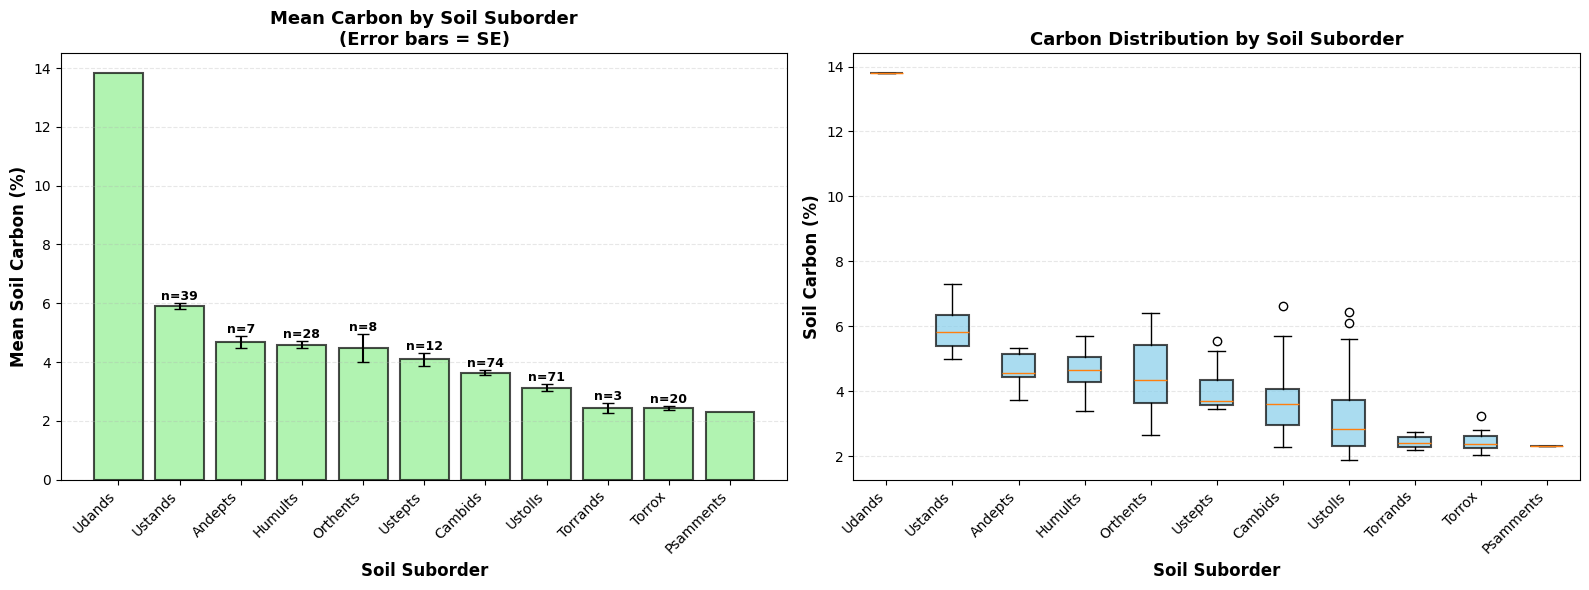


CARBON BY SOIL SUBORDER - SUMMARY
 Suborder      mean      std  count       se
   Udands 13.816728      NaN      1      NaN
  Ustands  5.908877 0.614685     39 0.098428
  Andepts  4.678620 0.569598      7 0.215288
  Humults  4.598287 0.621028     28 0.117363
 Orthents  4.474299 1.320827      8 0.466983
  Ustepts  4.090468 0.732164     12 0.211358
  Cambids  3.646185 0.832076     74 0.096727
  Ustolls  3.121862 1.008329     71 0.119667
 Torrands  2.441760 0.289858      3 0.167350
   Torrox  2.436414 0.300131     20 0.067111
Psamments  2.307327      NaN      1      NaN

ONE-WAY ANOVA
F-statistic: 56.448
p-value: 9.7994e-59
Significant at α=0.05: Yes

Interpretation: Soil suborder has a significant effect on carbon levels


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate summary stats for bar plot
suborder_stats = polygon_summary.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'count']
}).reset_index()
suborder_stats.columns = ['Suborder', 'mean', 'std', 'count']

# Calculate standard error
suborder_stats['se'] = suborder_stats['std'] / np.sqrt(suborder_stats['count'])

# Sort by mean carbon
suborder_stats = suborder_stats.sort_values('mean', ascending=False)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Bar plot with error bars
ax1 = axes[0]
x_pos = np.arange(len(suborder_stats))
bars = ax1.bar(x_pos, suborder_stats['mean'],
               yerr=suborder_stats['se'],
               capsize=4,
               alpha=0.7,
               color='#90EE90',
               edgecolor='black',
               linewidth=1.5)

# Add sample sizes on bars
for i, (idx, row) in enumerate(suborder_stats.iterrows()):
    ax1.text(i, row['mean'] + row['se'] + 0.1,
            f"n={int(row['count'])}",
            ha='center',
            fontsize=9,
            fontweight='bold')

ax1.set_ylabel('Mean Soil Carbon (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Soil Suborder', fontsize=12, fontweight='bold')
ax1.set_title('Mean Carbon by Soil Suborder\n(Error bars = SE)', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(suborder_stats['Suborder'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# RIGHT: Box plot
ax2 = axes[1]
suborder_order = suborder_stats['Suborder'].tolist()
boxplot_data = [polygon_summary[polygon_summary['Suborder_list'] == sub]['carbon_mean'].values
                for sub in suborder_order]

bp = ax2.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor('#87CEEB')
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

ax2.set_ylabel('Soil Carbon (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Soil Suborder', fontsize=12, fontweight='bold')
ax2.set_title('Carbon Distribution by Soil Suborder', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=10)
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("CARBON BY SOIL SUBORDER - SUMMARY")
print("="*80)
print(suborder_stats.to_string(index=False))

# Statistical test - ANOVA
from scipy import stats as scipy_stats
groups = [polygon_summary[polygon_summary['Suborder_list'] == sub]['carbon_mean'].values
          for sub in suborder_stats['Suborder']]
f_stat, p_value = scipy_stats.f_oneway(*groups)

print(f"\n" + "="*80)
print("ONE-WAY ANOVA")
print("="*80)
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value:.4e}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
print("\nInterpretation: ", end="")
if p_value < 0.05:
    print("Soil suborder has a significant effect on carbon levels")
else:
    print("No significant difference in carbon across soil suborders")

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# ============================================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================================
print("="*80)
print("CLIMATE GRADIENT STUDY: DESCRIPTIVE STATISTICS")
print("="*80)

print("\nSample size: n =", len(polygon_summary))
print("\nResponse variable (Soil Carbon %):")
print(f"  Mean ± SD: {polygon_summary['carbon_mean'].mean():.2f} ± {polygon_summary['carbon_mean'].std():.2f}%")
print(f"  Range: {polygon_summary['carbon_mean'].min():.2f} - {polygon_summary['carbon_mean'].max():.2f}%")

print("\nClimate gradient variables:")
print(f"  Temperature: {polygon_summary['tmax_ann_mean_30m'].min():.1f} - {polygon_summary['tmax_ann_mean_30m'].max():.1f}°C")
print(f"  Rainfall: {polygon_summary['rainfall_ann_mm_30m'].min():.0f} - {polygon_summary['rainfall_ann_mm_30m'].max():.0f} mm")

print("\nLand use distribution:")
print(polygon_summary['landuse_current'].value_counts())

print("\nLand use change:")
print(f"  Stable: {(~polygon_summary['land_use_changed']).sum()} polygons")
print(f"  Changed: {polygon_summary['land_use_changed'].sum()} polygons")

CLIMATE GRADIENT STUDY: DESCRIPTIVE STATISTICS

Sample size: n = 264

Response variable (Soil Carbon %):
  Mean ± SD: 3.94 ± 1.44%
  Range: 1.87 - 13.82%

Climate gradient variables:
  Temperature: 16.2 - 28.3°C
  Rainfall: 349 - 2721 mm

Land use distribution:
landuse_current
range        114
sugarcane     78
pineapple     70
Name: count, dtype: int64

Land use change:
  Stable: 158 polygons
  Changed: 106 polygons



CORRELATION MATRIX

Pearson correlations:
                     carbon_mean  tmax_ann_mean_30m  rainfall_ann_mm_30m  \
carbon_mean                1.000             -0.872                0.494   
tmax_ann_mean_30m         -0.872              1.000               -0.284   
rainfall_ann_mm_30m        0.494             -0.284                1.000   
carbon_change              0.519             -0.478                0.181   
carbon_pct_change          0.626             -0.564                0.322   

                     carbon_change  carbon_pct_change  
carbon_mean                  0.519              0.626  
tmax_ann_mean_30m           -0.478             -0.564  
rainfall_ann_mm_30m          0.181              0.322  
carbon_change                1.000              0.951  
carbon_pct_change            0.951              1.000  


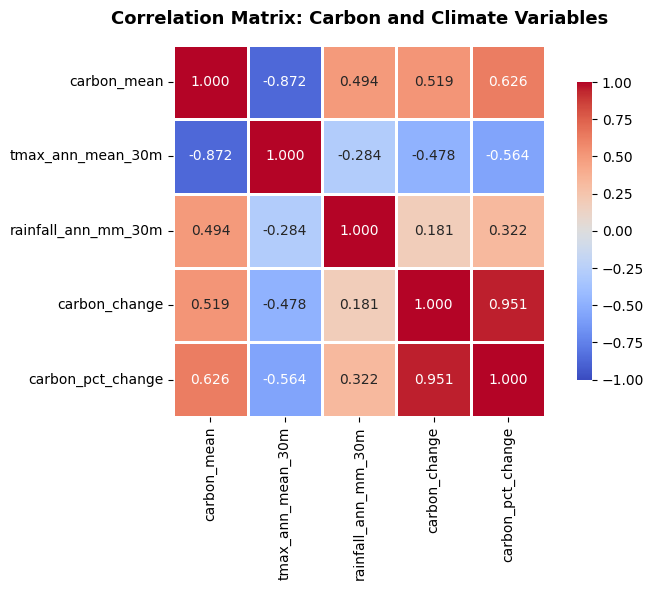

In [58]:
# ============================================================================
# 2. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)

# Create correlation matrix
corr_vars = ['carbon_mean', 'tmax_ann_mean_30m', 'rainfall_ann_mm_30m',
             'carbon_change', 'carbon_pct_change']
corr_matrix = polygon_summary[corr_vars].corr()

print("\nPearson correlations:")
print(corr_matrix.round(3))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, fmt='.3f', ax=ax)
ax.set_title('Correlation Matrix: Carbon and Climate Variables',
             fontweight='bold', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

In [59]:
# ============================================================================
# 3. SIMPLE LINEAR REGRESSIONS
# ============================================================================
print("\n" + "="*80)
print("SIMPLE LINEAR REGRESSIONS")
print("="*80)

from scipy.stats import linregress

# Temperature effect
slope_temp, intercept_temp, r_temp, p_temp, se_temp = linregress(
    polygon_summary['tmax_ann_mean_30m'].dropna(),
    polygon_summary['carbon_mean'].dropna()
)

print("\nModel 1: Carbon ~ Temperature")
print(f"  Equation: Carbon = {intercept_temp:.3f} + {slope_temp:.3f} × Temperature")
print(f"  R² = {r_temp**2:.3f}")
print(f"  p-value = {p_temp:.4e}")
print(f"  Interpretation: Each 1°C increase → {slope_temp:.3f}% carbon change")

# Rainfall effect
slope_rain, intercept_rain, r_rain, p_rain, se_rain = linregress(
    polygon_summary['rainfall_ann_mm_30m'].dropna(),
    polygon_summary['carbon_mean'].dropna()
)

print("\nModel 2: Carbon ~ Rainfall")
print(f"  Equation: Carbon = {intercept_rain:.3f} + {slope_rain:.6f} × Rainfall")
print(f"  R² = {r_rain**2:.3f}")
print(f"  p-value = {p_rain:.4e}")
print(f"  Interpretation: Each 100mm increase → {slope_rain*100:.3f}% carbon change")



SIMPLE LINEAR REGRESSIONS

Model 1: Carbon ~ Temperature
  Equation: Carbon = 20.650 + -0.641 × Temperature
  R² = 0.760
  p-value = 3.6742e-83
  Interpretation: Each 1°C increase → -0.641% carbon change

Model 2: Carbon ~ Rainfall
  Equation: Carbon = 2.807 + 0.001309 × Rainfall
  R² = 0.244
  p-value = 1.2700e-17
  Interpretation: Each 100mm increase → 0.131% carbon change


In [60]:
# ============================================================================
# 4. MULTIPLE REGRESSION
# ============================================================================
print("\n" + "="*80)
print("MULTIPLE LINEAR REGRESSION")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data
X = polygon_summary[['tmax_ann_mean_30m', 'rainfall_ann_mm_30m']].dropna()
y = polygon_summary.loc[X.index, 'carbon_mean']

# Fit model
mlr = LinearRegression()
mlr.fit(X, y)
y_pred = mlr.predict(X)
r2 = r2_score(y, y_pred)

print("\nModel 3: Carbon ~ Temperature + Rainfall")
print(f"  Equation: Carbon = {mlr.intercept_:.3f} + {mlr.coef_[0]:.3f}×Temp + {mlr.coef_[1]:.6f}×Rain")
print(f"  R² = {r2:.3f}")
print(f"  Temperature coefficient: {mlr.coef_[0]:.3f} (°C)")
print(f"  Rainfall coefficient: {mlr.coef_[1]:.6f} (mm)")


MULTIPLE LINEAR REGRESSION

Model 3: Carbon ~ Temperature + Rainfall
  Equation: Carbon = 18.578 + -0.585×Temp + 0.000710×Rain
  R² = 0.826
  Temperature coefficient: -0.585 (°C)
  Rainfall coefficient: 0.000710 (mm)



GENERATING CLIMATE GRADIENT VISUALIZATIONS


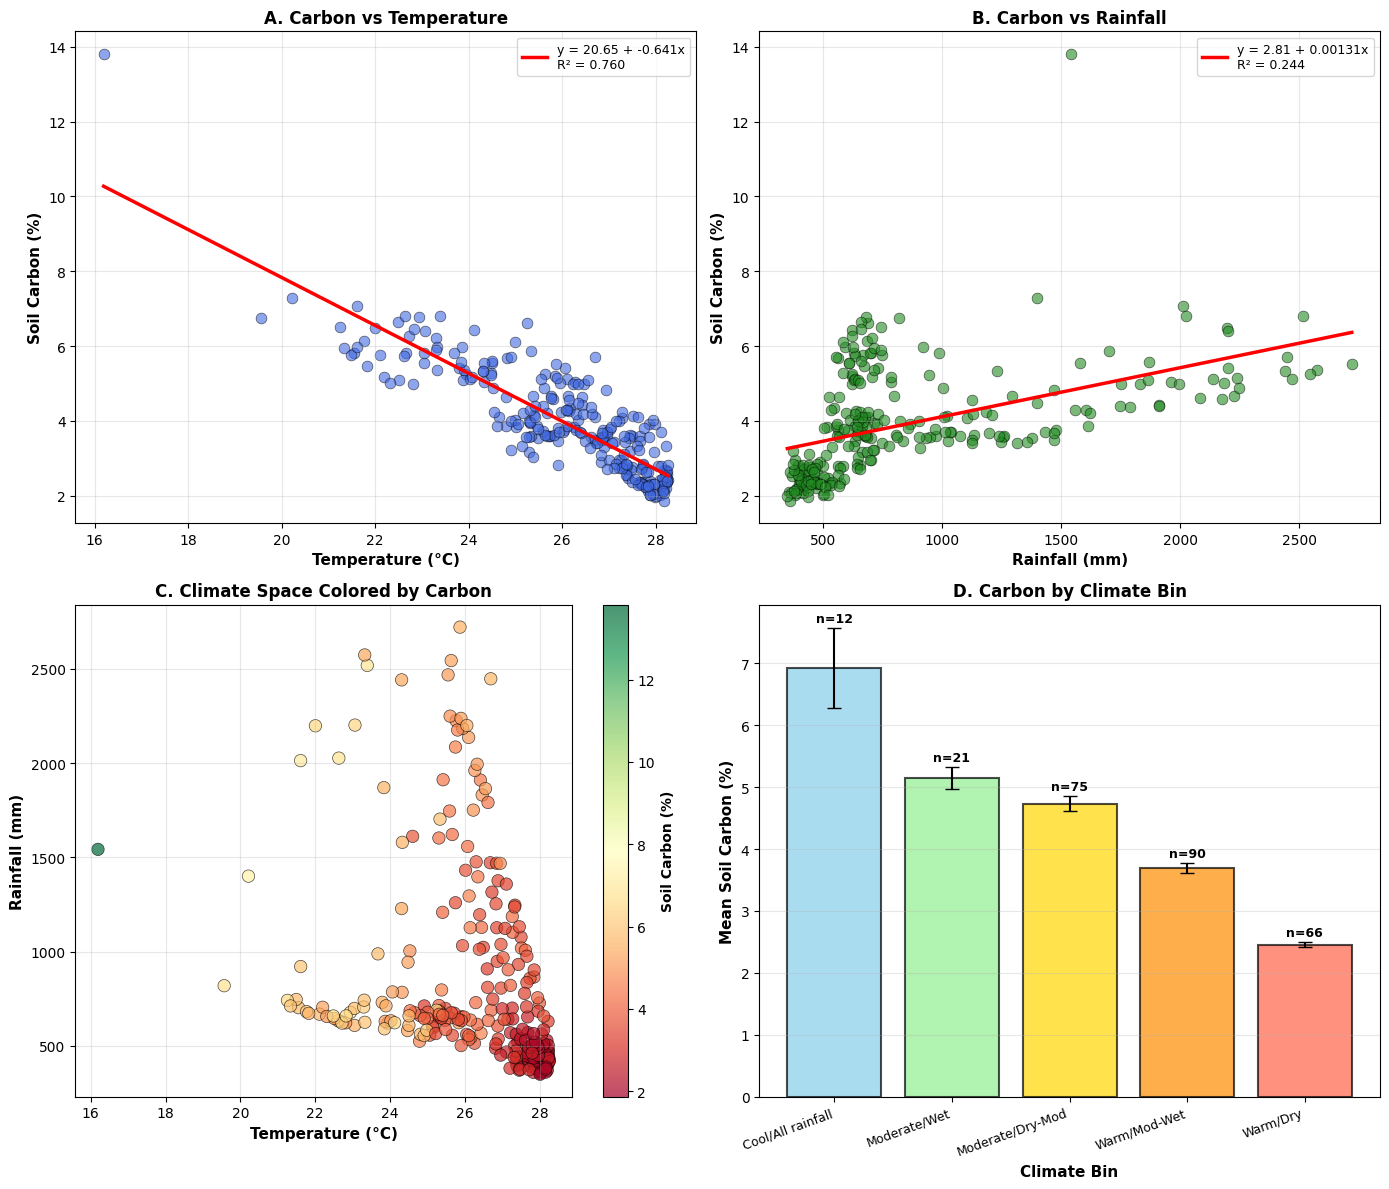

In [64]:
# ============================================================================
# 5. CLIMATE GRADIENT VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("GENERATING CLIMATE GRADIENT VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# A. Carbon vs Temperature with regression
ax1 = axes[0, 0]
ax1.scatter(polygon_summary['tmax_ann_mean_30m'], polygon_summary['carbon_mean'],
           alpha=0.6, s=60, edgecolors='black', linewidths=0.5, c='#4169E1')
x_temp = np.linspace(polygon_summary['tmax_ann_mean_30m'].min(),
                     polygon_summary['tmax_ann_mean_30m'].max(), 100)
y_temp = slope_temp * x_temp + intercept_temp
ax1.plot(x_temp, y_temp, 'r-', linewidth=2.5,
         label=f'y = {intercept_temp:.2f} + {slope_temp:.3f}x\nR² = {r_temp**2:.3f}')
ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('A. Carbon vs Temperature', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# B. Carbon vs Rainfall with regression
ax2 = axes[0, 1]
ax2.scatter(polygon_summary['rainfall_ann_mm_30m'], polygon_summary['carbon_mean'],
           alpha=0.6, s=60, edgecolors='black', linewidths=0.5, c='#228B22')
x_rain = np.linspace(polygon_summary['rainfall_ann_mm_30m'].min(),
                     polygon_summary['rainfall_ann_mm_30m'].max(), 100)
y_rain = slope_rain * x_rain + intercept_rain
ax2.plot(x_rain, y_rain, 'r-', linewidth=2.5,
         label=f'y = {intercept_rain:.2f} + {slope_rain:.5f}x\nR² = {r_rain**2:.3f}')
ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax2.set_title('B. Carbon vs Rainfall', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# C. 2D climate space colored by carbon
ax3 = axes[1, 0]
scatter = ax3.scatter(polygon_summary['tmax_ann_mean_30m'],
                     polygon_summary['rainfall_ann_mm_30m'],
                     c=polygon_summary['carbon_mean'],
                     cmap='RdYlGn', s=80, alpha=0.7,
                     edgecolors='black', linewidths=0.5)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Soil Carbon (%)', fontweight='bold', fontsize=10)
ax3.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax3.set_title('C. Climate Space Colored by Carbon', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)

# D. Carbon by climate bin
ax4 = axes[1, 1]
climate_bin_summary = polygon_summary.groupby('climate_description')['carbon_mean'].agg(['mean', 'std', 'count']).reset_index()
climate_bin_summary['se'] = climate_bin_summary['std'] / np.sqrt(climate_bin_summary['count'])
climate_bin_summary = climate_bin_summary.sort_values('mean', ascending=False)

x_pos = np.arange(len(climate_bin_summary))
bars = ax4.bar(x_pos, climate_bin_summary['mean'],
              yerr=climate_bin_summary['se'],
              capsize=5, alpha=0.7,
              color=['#87CEEB', '#90EE90', '#FFD700', '#FF8C00', '#FF6347'][:len(climate_bin_summary)],
              edgecolor='black', linewidth=1.5)

# Fix: iterate over enumerate to get correct x position
for i, (idx, row) in enumerate(climate_bin_summary.iterrows()):
    ax4.text(i, row['mean'] + row['se'] + 0.1,  # Use i instead of x_pos[i]
            f"n={int(row['count'])}", ha='center', fontsize=9, fontweight='bold')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(climate_bin_summary['climate_description'], rotation=20, ha='right', fontsize=9)
ax4.set_ylabel('Mean Soil Carbon (%)', fontweight='bold', fontsize=11)
ax4.set_xlabel('Climate Bin', fontweight='bold', fontsize=11)
ax4.set_title('D. Carbon by Climate Bin', fontweight='bold', fontsize=12)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


LAND USE EFFECTS ALONG CLIMATE GRADIENT

Sugarcane: Carbon ~ Temperature
  R² = 0.310, p = 0.0000

Pineapple: Carbon ~ Temperature
  R² = 0.404, p = 0.0000

Range: Carbon ~ Temperature
  R² = 0.773, p = 0.0000

Sugarcane: Carbon ~ Rainfall
  R² = 0.588, p = 0.0000

Pineapple: Carbon ~ Rainfall
  R² = 0.007, p = 0.4919

Range: Carbon ~ Rainfall
  R² = 0.177, p = 0.0000


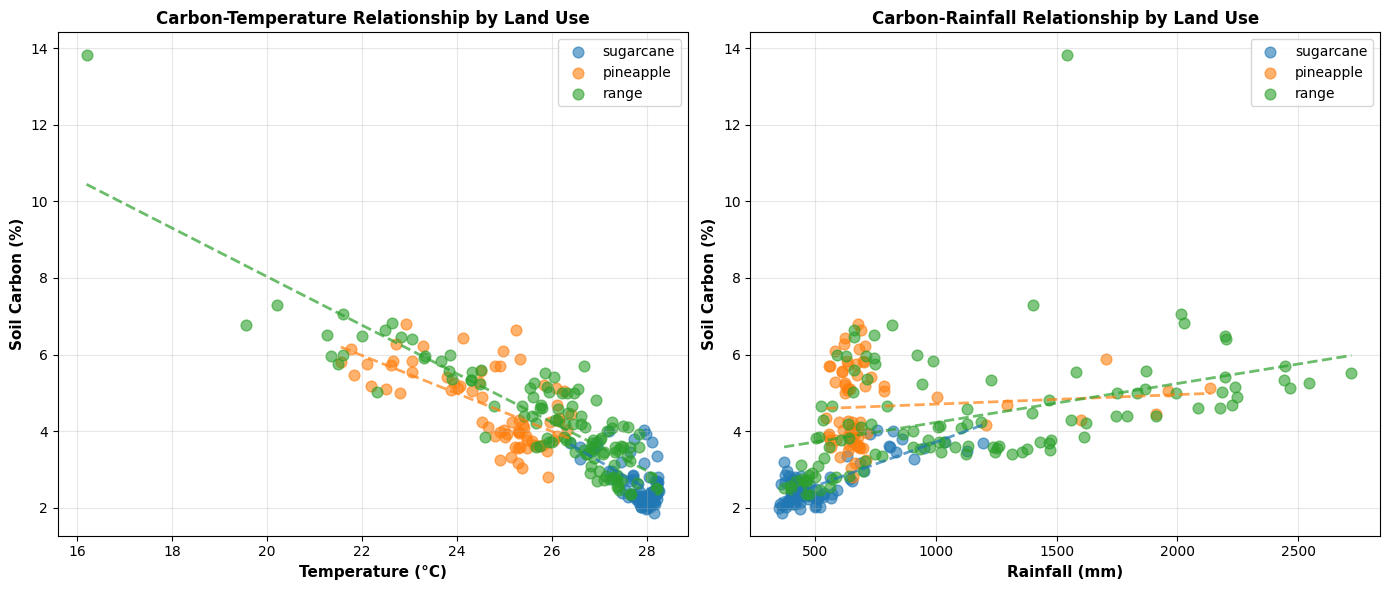


SUMMARY TABLE: CLIMATE GRADIENT EFFECTS
         Variable           Model       R²         Coefficient                            p-value
      Temperature   Simple Linear 0.759975           -0.640725                                0.0
         Rainfall   Simple Linear 0.243688            0.001309                                0.0
Temp + Rain (MLR) Multiple Linear 0.825990 T:-0.585, R:0.00071 N/A (use statsmodels for p-values)

Key findings:
  - Temperature explains 76.0% of carbon variation (strong negative effect)
  - Rainfall explains 24.4% of carbon variation (moderate positive effect)
  - Combined model explains 82.6% of variation


In [63]:
# ============================================================================
# 6. LAND USE EFFECTS ALONG CLIMATE GRADIENT
# ============================================================================
print("\n" + "="*80)
print("LAND USE EFFECTS ALONG CLIMATE GRADIENT")
print("="*80)

# Analyze by land use type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature by land use
ax1 = axes[0]
for landuse in ['sugarcane', 'pineapple', 'range']:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    if len(subset) > 0:
        ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
                   label=landuse, alpha=0.6, s=60)
        # Add regression line
        if len(subset) > 2:
            slope, intercept, r, p, se = linregress(subset['tmax_ann_mean_30m'], subset['carbon_mean'])
            x_range = np.linspace(subset['tmax_ann_mean_30m'].min(), subset['tmax_ann_mean_30m'].max(), 50)
            ax1.plot(x_range, slope * x_range + intercept, '--', linewidth=2, alpha=0.7)
            print(f"\n{landuse.capitalize()}: Carbon ~ Temperature")
            print(f"  R² = {r**2:.3f}, p = {p:.4f}")

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('Carbon-Temperature Relationship by Land Use', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Rainfall by land use
ax2 = axes[1]
for landuse in ['sugarcane', 'pineapple', 'range']:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    if len(subset) > 0:
        ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
                   label=landuse, alpha=0.6, s=60)
        # Add regression line
        if len(subset) > 2:
            slope, intercept, r, p, se = linregress(subset['rainfall_ann_mm_30m'], subset['carbon_mean'])
            x_range = np.linspace(subset['rainfall_ann_mm_30m'].min(), subset['rainfall_ann_mm_30m'].max(), 50)
            ax2.plot(x_range, slope * x_range + intercept, '--', linewidth=2, alpha=0.7)
            print(f"\n{landuse.capitalize()}: Carbon ~ Rainfall")
            print(f"  R² = {r**2:.3f}, p = {p:.4f}")

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax2.set_title('Carbon-Rainfall Relationship by Land Use', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("SUMMARY TABLE: CLIMATE GRADIENT EFFECTS")
print("="*80)

summary_table = pd.DataFrame({
    'Variable': ['Temperature', 'Rainfall', 'Temp + Rain (MLR)'],
    'Model': ['Simple Linear', 'Simple Linear', 'Multiple Linear'],
    'R²': [r_temp**2, r_rain**2, r2],
    'Coefficient': [slope_temp, slope_rain, f"T:{mlr.coef_[0]:.3f}, R:{mlr.coef_[1]:.5f}"],
    'p-value': [p_temp, p_rain, 'N/A (use statsmodels for p-values)']
})

print(summary_table.to_string(index=False))

print("\nKey findings:")
print(f"  - Temperature explains {r_temp**2*100:.1f}% of carbon variation (strong negative effect)")
print(f"  - Rainfall explains {r_rain**2*100:.1f}% of carbon variation (moderate positive effect)")
print(f"  - Combined model explains {r2*100:.1f}% of variation")


ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE

Sample size for ANCOVA: 262
Land use distribution:
landuse_current
range        114
sugarcane     78
pineapple     70
Name: count, dtype: int64

Actual land uses in data: ['sugarcane' 'range' 'pineapple']

--------------------------------------------------------------------------------
ANCOVA Model 1: Carbon ~ Temperature + Land Use
--------------------------------------------------------------------------------
                        sum_sq     df           F        PR(>F)
C(landuse_current)   12.675042    2.0   14.037316  1.633452e-06
tmax_ann_mean_30m   228.554533    1.0  506.237717  8.846448e-63
Residual            116.480988  258.0         NaN           NaN

Model R²: 0.782
Adjusted R²: 0.779

Parameter estimates:
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept          

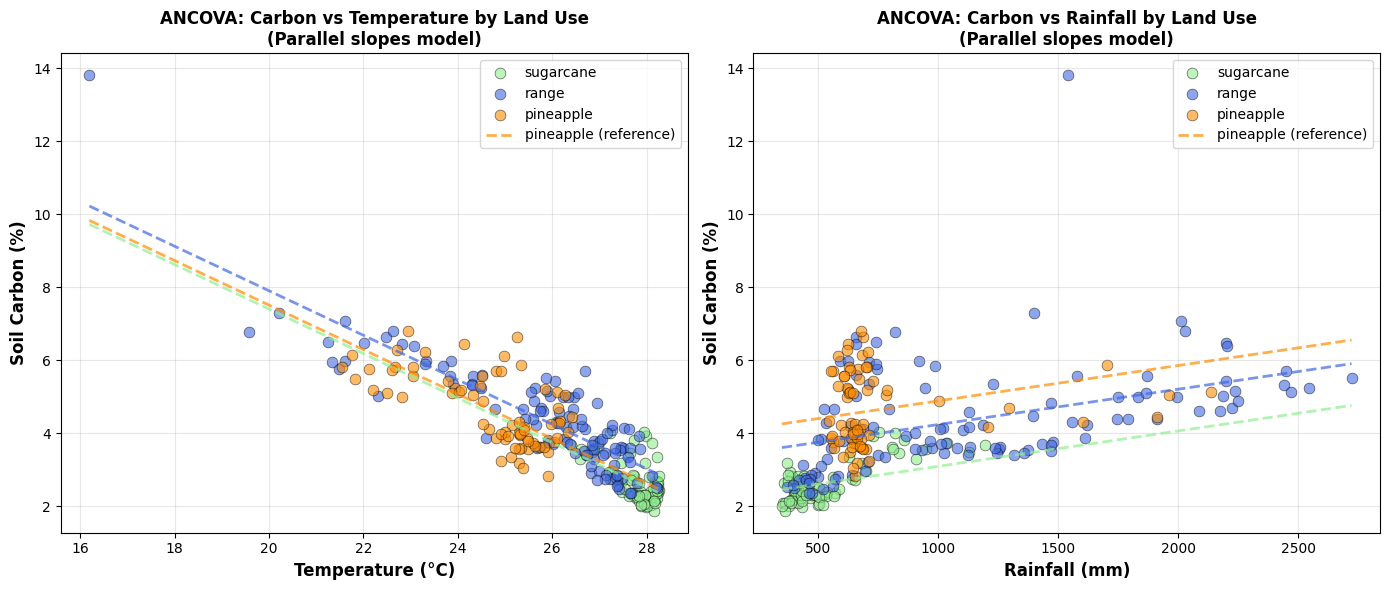

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# ============================================================================
# 8. ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE
# ============================================================================
print("\n" + "="*80)
print("ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE")
print("="*80)

# Prepare data - focus on main land uses
main_landuses = ['sugarcane', 'pineapple', 'range']
ancova_data = polygon_summary[polygon_summary['landuse_current'].isin(main_landuses)].copy()

print(f"\nSample size for ANCOVA: {len(ancova_data)}")
print(f"Land use distribution:")
print(ancova_data['landuse_current'].value_counts())

# Check which land uses actually exist
actual_landuses = ancova_data['landuse_current'].unique()
print(f"\nActual land uses in data: {actual_landuses}")

# ANCOVA Model 1: Carbon ~ Temperature + LandUse
model1 = ols('carbon_mean ~ tmax_ann_mean_30m + C(landuse_current)', data=ancova_data).fit()
anova_table1 = anova_lm(model1, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 1: Carbon ~ Temperature + Land Use")
print("-"*80)
print(anova_table1)
print(f"\nModel R²: {model1.rsquared:.3f}")
print(f"Adjusted R²: {model1.rsquared_adj:.3f}")

print("\nParameter estimates:")
print(model1.summary().tables[1])

# ANCOVA Model 2: Carbon ~ Rainfall + LandUse
model2 = ols('carbon_mean ~ rainfall_ann_mm_30m + C(landuse_current)', data=ancova_data).fit()
anova_table2 = anova_lm(model2, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 2: Carbon ~ Rainfall + Land Use")
print("-"*80)
print(anova_table2)
print(f"\nModel R²: {model2.rsquared:.3f}")
print(f"Adjusted R²: {model2.rsquared_adj:.3f}")

# ANCOVA Model 3: Carbon ~ Temperature + Rainfall + LandUse
model3 = ols('carbon_mean ~ tmax_ann_mean_30m + rainfall_ann_mm_30m + C(landuse_current)',
             data=ancova_data).fit()
anova_table3 = anova_lm(model3, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 3: Carbon ~ Temperature + Rainfall + Land Use")
print("-"*80)
print(anova_table3)
print(f"\nModel R²: {model3.rsquared:.3f}")
print(f"Adjusted R²: {model3.rsquared_adj:.3f}")

# Visualize ANCOVA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature with land use
ax1 = axes[0]
colors_lu = {'sugarcane': '#90EE90', 'pineapple': '#FF8C00', 'range': '#4169E1'}
for landuse in actual_landuses:  # Use actual_landuses instead of main_landuses
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu.get(landuse, 'gray'),
               edgecolors='black', linewidths=0.5)

# Add ANCOVA fitted lines (parallel slopes from model without interaction)
temp_range = np.linspace(ancova_data['tmax_ann_mean_30m'].min(),
                         ancova_data['tmax_ann_mean_30m'].max(), 100)
temp_coef = model1.params['tmax_ann_mean_30m']
intercept_base = model1.params['Intercept']

# Plot line for reference category (first in alphabetical order)
ref_landuse = sorted(actual_landuses)[0]
ax1.plot(temp_range, intercept_base + temp_coef * temp_range, '--',
         color=colors_lu.get(ref_landuse, 'gray'), linewidth=2, alpha=0.7,
         label=f'{ref_landuse} (reference)')

# Plot lines for other categories
for landuse in sorted(actual_landuses)[1:]:
    param_name = f'C(landuse_current)[T.{landuse}]'
    if param_name in model1.params:
        intercept_landuse = intercept_base + model1.params[param_name]
        ax1.plot(temp_range, intercept_landuse + temp_coef * temp_range, '--',
                color=colors_lu.get(landuse, 'gray'), linewidth=2, alpha=0.7)

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_title('ANCOVA: Carbon vs Temperature by Land Use\n(Parallel slopes model)',
              fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Rainfall with land use
ax2 = axes[1]
for landuse in actual_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu.get(landuse, 'gray'),
               edgecolors='black', linewidths=0.5)

# Add ANCOVA fitted lines
rain_range = np.linspace(ancova_data['rainfall_ann_mm_30m'].min(),
                         ancova_data['rainfall_ann_mm_30m'].max(), 100)
rain_coef = model2.params['rainfall_ann_mm_30m']
intercept_base2 = model2.params['Intercept']

# Plot line for reference category
ax2.plot(rain_range, intercept_base2 + rain_coef * rain_range, '--',
         color=colors_lu.get(ref_landuse, 'gray'), linewidth=2, alpha=0.7,
         label=f'{ref_landuse} (reference)')

# Plot lines for other categories
for landuse in sorted(actual_landuses)[1:]:
    param_name = f'C(landuse_current)[T.{landuse}]'
    if param_name in model2.params:
        intercept_landuse2 = intercept_base2 + model2.params[param_name]
        ax2.plot(rain_range, intercept_landuse2 + rain_coef * rain_range, '--',
                color=colors_lu.get(landuse, 'gray'), linewidth=2, alpha=0.7)

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax2.set_title('ANCOVA: Carbon vs Rainfall by Land Use\n(Parallel slopes model)',
              fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()





INTERACTION EFFECTS: CLIMATE × LAND USE

--------------------------------------------------------------------------------
Interaction Model 1: Carbon ~ Temperature × Land Use
--------------------------------------------------------------------------------
                                          sum_sq     df           F  \
C(landuse_current)                     12.675042    2.0   14.162870   
tmax_ann_mean_30m                     228.554533    1.0  510.765671   
tmax_ann_mean_30m:C(landuse_current)    1.927556    2.0    2.153818   
Residual                              114.553432  256.0         NaN   

                                            PR(>F)  
C(landuse_current)                    1.466374e-06  
tmax_ann_mean_30m                     6.348510e-63  
tmax_ann_mean_30m:C(landuse_current)  1.181385e-01  
Residual                                       NaN  

Model R²: 0.785
Adjusted R²: 0.781

--------------------------------------------------------------------------------
Inte

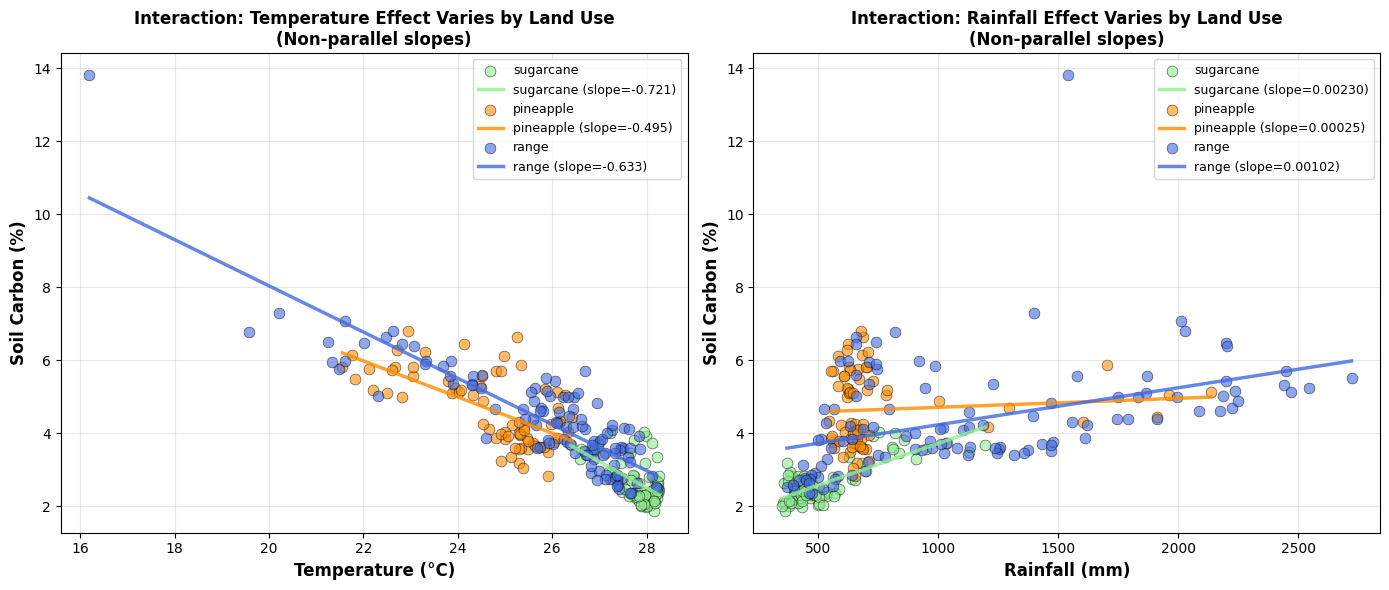


INTERACTION SIGNIFICANCE TESTS

Temperature × Land Use interaction:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     258.0  116.480988      0.0       NaN       NaN       NaN
1     256.0  114.553432      2.0  1.927556  2.153818  0.118139
  → Interaction is NOT significant: Parallel slopes model is sufficient

Rainfall × Land Use interaction:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     258.0  294.494139      0.0       NaN       NaN       NaN
1     256.0  285.550873      2.0  8.943265  4.008876  0.019305
  → Interaction is SIGNIFICANT: Rainfall effect differs by land use


In [67]:
# ============================================================================
# 9. INTERACTION EFFECTS: DOES CLIMATE EFFECT DIFFER BY LAND USE?
# ============================================================================
print("\n" + "="*80)
print("INTERACTION EFFECTS: CLIMATE × LAND USE")
print("="*80)

# Model with Temperature × LandUse interaction
model_int1 = ols('carbon_mean ~ tmax_ann_mean_30m * C(landuse_current)',
                 data=ancova_data).fit()
anova_int1 = anova_lm(model_int1, typ=2)

print("\n" + "-"*80)
print("Interaction Model 1: Carbon ~ Temperature × Land Use")
print("-"*80)
print(anova_int1)
print(f"\nModel R²: {model_int1.rsquared:.3f}")
print(f"Adjusted R²: {model_int1.rsquared_adj:.3f}")

# Model with Rainfall × LandUse interaction
model_int2 = ols('carbon_mean ~ rainfall_ann_mm_30m * C(landuse_current)',
                 data=ancova_data).fit()
anova_int2 = anova_lm(model_int2, typ=2)

print("\n" + "-"*80)
print("Interaction Model 2: Carbon ~ Rainfall × Land Use")
print("-"*80)
print(anova_int2)
print(f"\nModel R²: {model_int2.rsquared:.3f}")
print(f"Adjusted R²: {model_int2.rsquared_adj:.3f}")

# Full interaction model
model_int3 = ols('carbon_mean ~ (tmax_ann_mean_30m + rainfall_ann_mm_30m) * C(landuse_current)',
                 data=ancova_data).fit()
anova_int3 = anova_lm(model_int3, typ=2)

print("\n" + "-"*80)
print("Full Interaction Model: Carbon ~ (Temp + Rain) × Land Use")
print("-"*80)
print(anova_int3)
print(f"\nModel R²: {model_int3.rsquared:.3f}")
print(f"Adjusted R²: {model_int3.rsquared_adj:.3f}")

# Visualize interaction effects (non-parallel slopes)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature interaction
ax1 = axes[0]
for landuse in main_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu[landuse],
               edgecolors='black', linewidths=0.5)

    # Fit separate regression lines (non-parallel)
    if len(subset) > 2:
        slope, intercept, r, p, se = stats.linregress(subset['tmax_ann_mean_30m'],
                                                       subset['carbon_mean'])
        x_range = np.linspace(subset['tmax_ann_mean_30m'].min(),
                             subset['tmax_ann_mean_30m'].max(), 50)
        ax1.plot(x_range, slope * x_range + intercept, '-',
                color=colors_lu[landuse], linewidth=2.5, alpha=0.8,
                label=f'{landuse} (slope={slope:.3f})')

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_title('Interaction: Temperature Effect Varies by Land Use\n(Non-parallel slopes)',
              fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Rainfall interaction
ax2 = axes[1]
for landuse in main_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu[landuse],
               edgecolors='black', linewidths=0.5)

    # Fit separate regression lines (non-parallel)
    if len(subset) > 2:
        slope, intercept, r, p, se = stats.linregress(subset['rainfall_ann_mm_30m'],
                                                       subset['carbon_mean'])
        x_range = np.linspace(subset['rainfall_ann_mm_30m'].min(),
                             subset['rainfall_ann_mm_30m'].max(), 50)
        ax2.plot(x_range, slope * x_range + intercept, '-',
                color=colors_lu[landuse], linewidth=2.5, alpha=0.8,
                label=f'{landuse} (slope={slope:.5f})')

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax2.set_title('Interaction: Rainfall Effect Varies by Land Use\n(Non-parallel slopes)',
              fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test significance of interaction
print("\n" + "="*80)
print("INTERACTION SIGNIFICANCE TESTS")
print("="*80)

# Compare models with and without interaction
from statsmodels.stats.anova import anova_lm

# Temperature interaction test
comparison1 = anova_lm(model1, model_int1)
print("\nTemperature × Land Use interaction:")
print(comparison1)
if comparison1['Pr(>F)'][1] < 0.05:
    print("  → Interaction is SIGNIFICANT: Temperature effect differs by land use")
else:
    print("  → Interaction is NOT significant: Parallel slopes model is sufficient")

# Rainfall interaction test
comparison2 = anova_lm(model2, model_int2)
print("\nRainfall × Land Use interaction:")
print(comparison2)
if comparison2['Pr(>F)'][1] < 0.05:
    print("  → Interaction is SIGNIFICANT: Rainfall effect differs by land use")
else:
    print("  → Interaction is NOT significant: Parallel slopes model is sufficient")


SOIL SUBORDER EFFECTS ON CARBON

Analyzing suborders with n ≥ 5
Included suborders: ['Cambids', 'Ustolls', 'Ustands', 'Humults', 'Torrox', 'Ustepts', 'Orthents', 'Andepts']

--------------------------------------------------------------------------------
One-Way ANOVA: Carbon ~ Soil Suborder
--------------------------------------------------------------------------------
F-statistic: 57.280
p-value: 1.5555e-48
  → Soil suborder has SIGNIFICANT effect on carbon

Carbon by Soil Suborder:
               carbon_mean  carbon_std   n  temp_mean  rain_mean
Suborder_list                                                   
Ustands               5.91        0.61  39      22.64     959.80
Andepts               4.68        0.57   7      25.96    1753.22
Humults               4.60        0.62  28      26.07    1884.40
Orthents              4.47        1.32   8      26.04    1028.05
Ustepts               4.09        0.73  12      25.94    1232.62
Cambids               3.65        0.83  74      26.10

/tmp/ipython-input-1933586771.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)


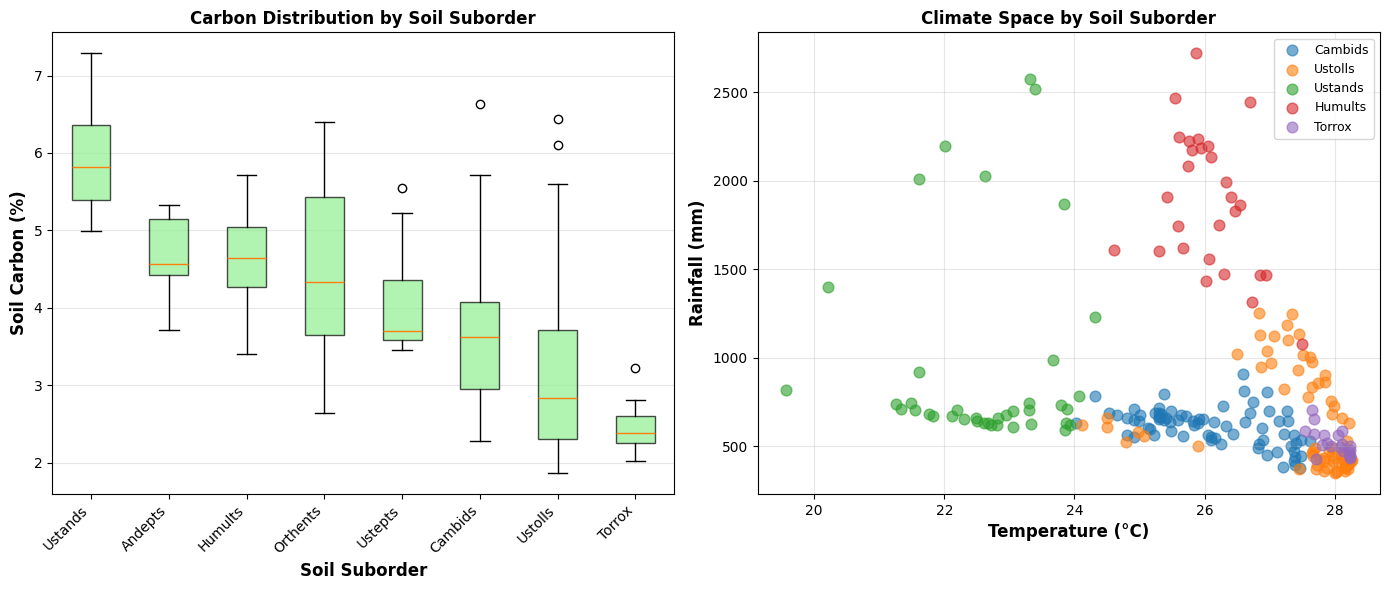

In [68]:
# ============================================================================
# 10. SOIL SUBORDER EFFECTS
# ============================================================================
print("\n" + "="*80)
print("SOIL SUBORDER EFFECTS ON CARBON")
print("="*80)

# Filter to suborders with sufficient sample size
suborder_counts = polygon_summary['Suborder_list'].value_counts()
min_n = 5
common_suborders = suborder_counts[suborder_counts >= min_n].index.tolist()

print(f"\nAnalyzing suborders with n ≥ {min_n}")
print(f"Included suborders: {common_suborders}")

soil_data = polygon_summary[polygon_summary['Suborder_list'].isin(common_suborders)].copy()

# ANOVA: Carbon by Suborder
suborder_groups = [soil_data[soil_data['Suborder_list'] == sub]['carbon_mean'].values
                   for sub in common_suborders]
f_stat, p_val = stats.f_oneway(*suborder_groups)

print("\n" + "-"*80)
print("One-Way ANOVA: Carbon ~ Soil Suborder")
print("-"*80)
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.4e}")
if p_val < 0.05:
    print("  → Soil suborder has SIGNIFICANT effect on carbon")
else:
    print("  → No significant difference in carbon across soil suborders")

# Summary stats by suborder
print("\nCarbon by Soil Suborder:")
suborder_summary = soil_data.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'count'],
    'tmax_ann_mean_30m': 'mean',
    'rainfall_ann_mm_30m': 'mean'
}).round(2)
suborder_summary.columns = ['carbon_mean', 'carbon_std', 'n', 'temp_mean', 'rain_mean']
suborder_summary = suborder_summary.sort_values('carbon_mean', ascending=False)
print(suborder_summary)

# ANCOVA: Carbon ~ Climate + Suborder
soil_model = ols('carbon_mean ~ tmax_ann_mean_30m + rainfall_ann_mm_30m + C(Suborder_list)',
                 data=soil_data).fit()
soil_anova = anova_lm(soil_model, typ=2)

print("\n" + "-"*80)
print("ANCOVA: Carbon ~ Temperature + Rainfall + Soil Suborder")
print("-"*80)
print(soil_anova)
print(f"\nModel R²: {soil_model.rsquared:.3f}")
print(f"Adjusted R²: {soil_model.rsquared_adj:.3f}")

# Visualize soil suborder effects
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot by suborder
ax1 = axes[0]
suborder_order = suborder_summary.index.tolist()
boxplot_data = [soil_data[soil_data['Suborder_list'] == sub]['carbon_mean'].values
                for sub in suborder_order]
bp = ax1.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#90EE90')
    patch.set_alpha(0.7)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Soil Suborder', fontweight='bold', fontsize=12)
ax1.set_title('Carbon Distribution by Soil Suborder', fontweight='bold', fontsize=12)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Climate space colored by suborder
ax2 = axes[1]
for suborder in common_suborders[:5]:  # Top 5 most common
    subset = soil_data[soil_data['Suborder_list'] == suborder]
    ax2.scatter(subset['tmax_ann_mean_30m'], subset['rainfall_ann_mm_30m'],
               label=suborder, alpha=0.6, s=60)
ax2.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_title('Climate Space by Soil Suborder', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
# ============================================================================
# 11. TEMPORAL CHANGE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("TEMPORAL CHANGE ANALYSIS (2016-2024)")
print("="*80)

# Overall temporal trends
print("\nOverall carbon change:")
print(f"  Mean change: {polygon_summary['carbon_change'].mean():.3f}% ({polygon_summary['carbon_pct_change'].mean():.2f}%)")
print(f"  Std: {polygon_summary['carbon_change'].std():.3f}%")
print(f"  Range: {polygon_summary['carbon_change'].min():.3f} to {polygon_summary['carbon_change'].max():.3f}%")

# Test if overall change is significant
t_stat, p_val = stats.ttest_1samp(polygon_summary['carbon_change'].dropna(), 0)
print(f"\nOne-sample t-test (H0: change = 0):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_val:.4e}")
if p_val < 0.05:
    if polygon_summary['carbon_change'].mean() > 0:
        print("  → Carbon INCREASED significantly over time")
    else:
        print("  → Carbon DECREASED significantly over time")
else:
    print("  → No significant change in carbon over time")

# Temporal change by land use
print("\n" + "-"*80)
print("Temporal change by current land use:")
print("-"*80)
temporal_by_landuse = polygon_summary.groupby('landuse_current').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_pct_change': 'mean'
}).round(3)
temporal_by_landuse.columns = ['change_mean', 'change_std', 'n', 'pct_change']
print(temporal_by_landuse)

# Test temporal change by land use type
for landuse in main_landuses:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    t_stat, p_val = stats.ttest_1samp(subset['carbon_change'].dropna(), 0)
    print(f"\n{landuse.capitalize()}: mean change = {subset['carbon_change'].mean():.3f}%, p = {p_val:.4f}")

# Temporal change by transition type
print("\n" + "-"*80)
print("Temporal change by land use transition:")
print("-"*80)
key_transitions = ['sugarcane → sugarcane', 'sugarcane → range',
                   'pineapple → pineapple', 'pineapple → range']
trans_temporal = polygon_summary[polygon_summary['transition'].isin(key_transitions)]

temporal_by_transition = trans_temporal.groupby('transition').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_pct_change': 'mean'
}).round(3)
temporal_by_transition.columns = ['change_mean', 'change_std', 'n', 'pct_change']
print(temporal_by_transition)

# Climate gradient effects on temporal change
print("\n" + "-"*80)
print("Climate effects on temporal carbon change:")
print("-"*80)

# Correlation: Does climate predict carbon change?
corr_temp_change = polygon_summary[['tmax_ann_mean_30m', 'carbon_change']].corr().iloc[0, 1]
corr_rain_change = polygon_summary[['rainfall_ann_mm_30m', 'carbon_change']].corr().iloc[0, 1]

print(f"\nCorrelation: Temperature vs Carbon Change: r = {corr_temp_change:.3f}")
print(f"Correlation: Rainfall vs Carbon Change: r = {corr_rain_change:.3f}")

# Regression: Carbon change ~ Climate
slope_t, intercept_t, r_t, p_t, se_t = stats.linregress(
    polygon_summary['tmax_ann_mean_30m'].dropna(),
    polygon_summary['carbon_change'].dropna()
)
print(f"\nRegression: Carbon Change ~ Temperature")
print(f"  Slope: {slope_t:.4f}, R² = {r_t**2:.3f}, p = {p_t:.4f}")

slope_r, intercept_r, r_r, p_r, se_r = stats.linregress(
    polygon_summary['rainfall_ann_mm_30m'].dropna(),
    polygon_summary['carbon_change'].dropna()
)
print(f"\nRegression: Carbon Change ~ Rainfall")
print(f"  Slope: {slope_r:.6f}, R² = {r_r**2:.3f}, p = {p_r:.4f}")


TEMPORAL CHANGE ANALYSIS (2016-2024)

Overall carbon change:
  Mean change: -0.526% (-14.77%)
  Std: 0.587%
  Range: -2.217 to 2.560%

One-sample t-test (H0: change = 0):
  t-statistic: -14.550
  p-value: 1.3789e-35
  → Carbon DECREASED significantly over time

--------------------------------------------------------------------------------
Temporal change by current land use:
--------------------------------------------------------------------------------
                 change_mean  change_std    n  pct_change
landuse_current                                          
pineapple             -0.105       0.530   70      -1.536
range                 -0.457       0.448  114     -11.105
sugarcane             -0.986       0.476   78     -31.975

Sugarcane: mean change = -0.986%, p = 0.0000

Pineapple: mean change = -0.105%, p = 0.1036

Range: mean change = -0.457%, p = 0.0000

--------------------------------------------------------------------------------
Temporal change by land use tran

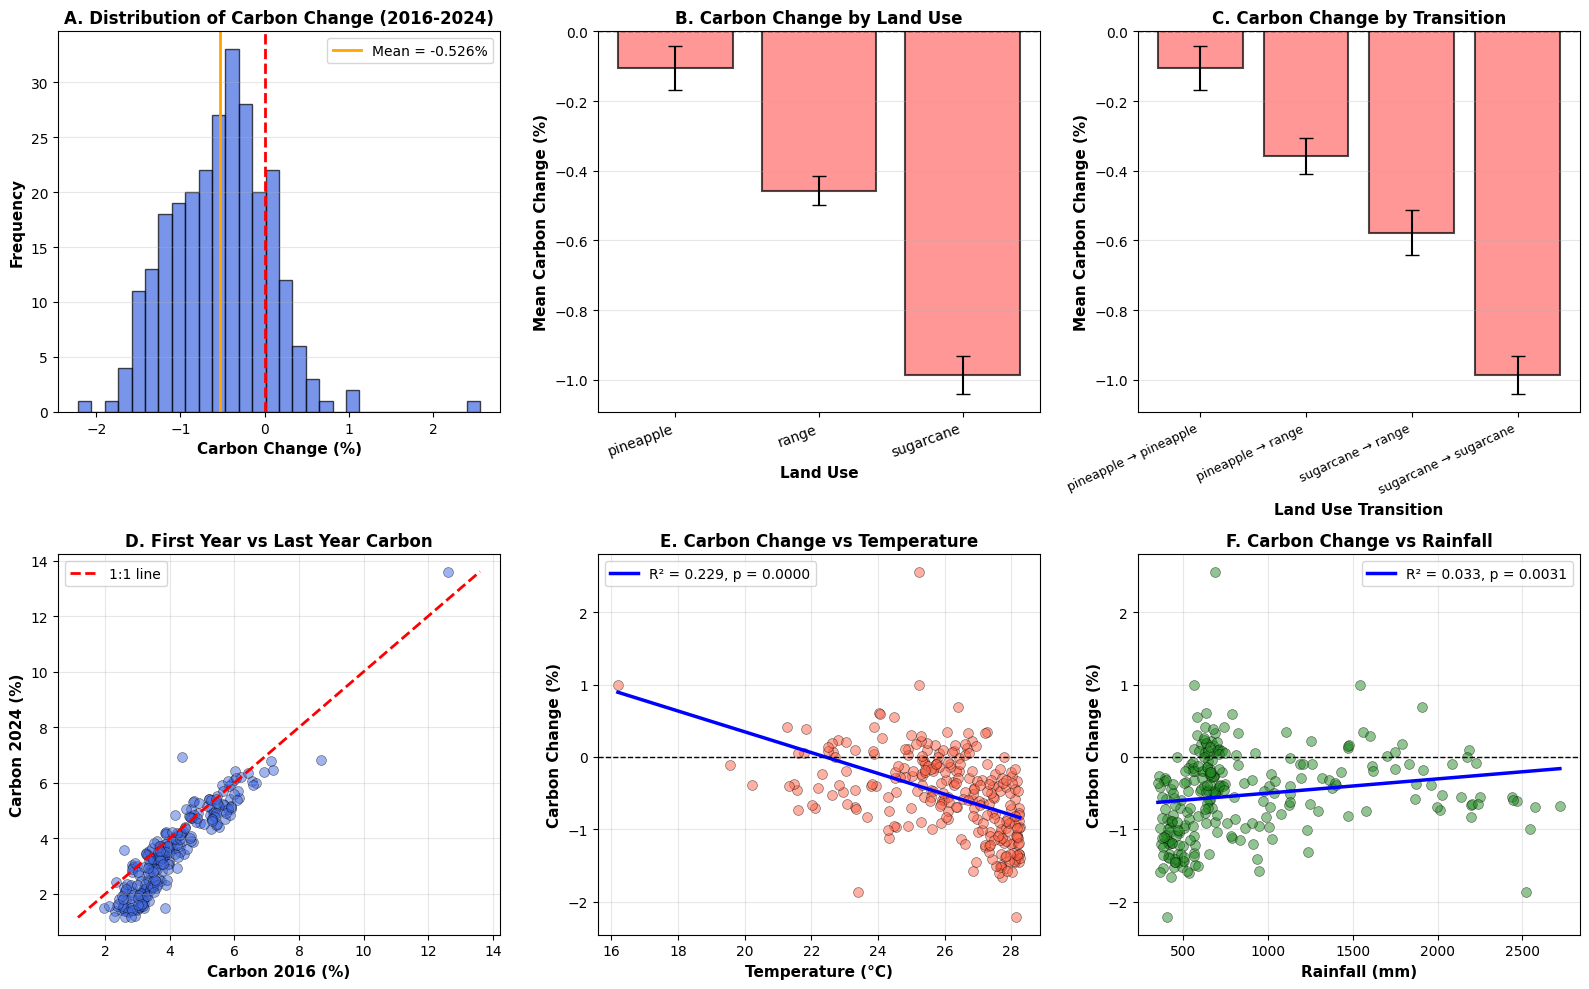

In [70]:
# Visualizations
fig = plt.figure(figsize=(16, 10))

# A. Overall temporal change distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(polygon_summary['carbon_change'], bins=30, alpha=0.7,
         color='#4169E1', edgecolor='black')
ax1.axvline(0, color='red', linestyle='--', linewidth=2)
ax1.axvline(polygon_summary['carbon_change'].mean(), color='orange',
            linestyle='-', linewidth=2, label=f"Mean = {polygon_summary['carbon_change'].mean():.3f}%")
ax1.set_xlabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax1.set_title('A. Distribution of Carbon Change (2016-2024)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# B. Temporal change by land use
ax2 = plt.subplot(2, 3, 2)
temporal_lu = temporal_by_landuse.reset_index()
x_pos = np.arange(len(temporal_lu))
colors_change = ['#90EE90' if x > 0 else '#FF6B6B' for x in temporal_lu['change_mean']]
bars = ax2.bar(x_pos, temporal_lu['change_mean'],
               yerr=temporal_lu['change_std'] / np.sqrt(temporal_lu['n']),
               capsize=5, alpha=0.7, color=colors_change,
               edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(temporal_lu['landuse_current'], rotation=20, ha='right')
ax2.set_ylabel('Mean Carbon Change (%)', fontweight='bold', fontsize=11)
ax2.set_xlabel('Land Use', fontweight='bold', fontsize=11)
ax2.set_title('B. Carbon Change by Land Use', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

# C. Temporal change by transition
ax3 = plt.subplot(2, 3, 3)
temporal_trans = temporal_by_transition.reset_index()
x_pos = np.arange(len(temporal_trans))
colors_trans = ['#90EE90' if x > 0 else '#FF6B6B' for x in temporal_trans['change_mean']]
bars = ax3.bar(x_pos, temporal_trans['change_mean'],
               yerr=temporal_trans['change_std'] / np.sqrt(temporal_trans['n']),
               capsize=5, alpha=0.7, color=colors_trans,
               edgecolor='black', linewidth=1.5)
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(temporal_trans['transition'], rotation=25, ha='right', fontsize=9)
ax3.set_ylabel('Mean Carbon Change (%)', fontweight='bold', fontsize=11)
ax3.set_xlabel('Land Use Transition', fontweight='bold', fontsize=11)
ax3.set_title('C. Carbon Change by Transition', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3, axis='y')

# D. First year vs last year
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(polygon_summary['carbon_first_year'], polygon_summary['carbon_last_year'],
           alpha=0.5, s=50, c='#4169E1', edgecolors='black', linewidths=0.5)
# Add 1:1 line
min_val = min(polygon_summary['carbon_first_year'].min(), polygon_summary['carbon_last_year'].min())
max_val = max(polygon_summary['carbon_first_year'].max(), polygon_summary['carbon_last_year'].max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')
ax4.set_xlabel('Carbon 2016 (%)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Carbon 2024 (%)', fontweight='bold', fontsize=11)
ax4.set_title('D. First Year vs Last Year Carbon', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

# E. Carbon change vs Temperature
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(polygon_summary['tmax_ann_mean_30m'], polygon_summary['carbon_change'],
           alpha=0.5, s=50, c='#FF6347', edgecolors='black', linewidths=0.5)
x_temp = np.linspace(polygon_summary['tmax_ann_mean_30m'].min(),
                     polygon_summary['tmax_ann_mean_30m'].max(), 100)
y_temp = slope_t * x_temp + intercept_t
ax5.plot(x_temp, y_temp, 'b-', linewidth=2.5,
         label=f'R² = {r_t**2:.3f}, p = {p_t:.4f}')
ax5.axhline(0, color='black', linestyle='--', linewidth=1)
ax5.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax5.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax5.set_title('E. Carbon Change vs Temperature', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(alpha=0.3)

# F. Carbon change vs Rainfall
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(polygon_summary['rainfall_ann_mm_30m'], polygon_summary['carbon_change'],
           alpha=0.5, s=50, c='#228B22', edgecolors='black', linewidths=0.5)
x_rain = np.linspace(polygon_summary['rainfall_ann_mm_30m'].min(),
                     polygon_summary['rainfall_ann_mm_30m'].max(), 100)
y_rain = slope_r * x_rain + intercept_r
ax6.plot(x_rain, y_rain, 'b-', linewidth=2.5,
         label=f'R² = {r_r**2:.3f}, p = {p_r:.4f}')
ax6.axhline(0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax6.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax6.set_title('F. Carbon Change vs Rainfall', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# ============================================================================
# 12. COMPREHENSIVE SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY: ALL MODELS")
print("="*80)

summary_results = pd.DataFrame({
    'Analysis': [
        'Simple: Carbon ~ Temperature',
        'Simple: Carbon ~ Rainfall',
        'Multiple: Carbon ~ Temp + Rain',
        'ANCOVA: Carbon ~ Temp + LandUse',
        'ANCOVA: Carbon ~ Rain + LandUse',
        'ANCOVA: Carbon ~ Temp + Rain + LandUse',
        'Interaction: Carbon ~ Temp × LandUse',
        'Interaction: Carbon ~ Rain × LandUse',
        'Soil: Carbon ~ Temp + Rain + Suborder',
        'Temporal: Change ~ Temperature',
        'Temporal: Change ~ Rainfall'
    ],
    'R²': [
        r_temp**2,
        r_rain**2,
        r2,
        model1.rsquared,
        model2.rsquared,
        model3.rsquared,
        model_int1.rsquared,
        model_int2.rsquared,
        soil_model.rsquared,
        r_t**2,
        r_r**2
    ],
    'Adj_R²': [
        np.nan,
        np.nan,
        np.nan,
        model1.rsquared_adj,
        model2.rsquared_adj,
        model3.rsquared_adj,
        model_int1.rsquared_adj,
        model_int2.rsquared_adj,
        soil_model.rsquared_adj,
        np.nan,
        np.nan
    ],
    'Key_Finding': [
        f'Strong negative effect (β={slope_temp:.3f})',
        f'Moderate positive effect (β={slope_rain:.5f})',
        f'Both predictors significant',
        f'LandUse effect p={anova_table1["PR(>F)"][1]:.4f}',
        f'LandUse effect p={anova_table2["PR(>F)"][1]:.4f}',
        f'All factors significant',
        f'Interaction p={comparison1["Pr(>F)"][1]:.4f}',
        f'Interaction p={comparison2["Pr(>F)"][1]:.4f}',
        f'Suborder effect p={soil_anova["PR(>F)"][2]:.4f}',
        f'Weak/no relationship (p={p_t:.3f})',
        f'Weak/no relationship (p={p_r:.3f})'
    ]
})

print(summary_results.to_string(index=False))

# ============================================================================
# 13. FINAL KEY FINDINGS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS: CLIMATE GRADIENT EFFECTS ON SOIL CARBON")
print("="*80)

print("\n1. CLIMATE GRADIENT EFFECTS:")
print(f"   • Temperature strongly controls carbon (R² = {r_temp**2:.3f})")
print(f"     - Each 1°C increase → {slope_temp:.3f}% carbon decrease")
print(f"   • Rainfall moderately affects carbon (R² = {r_rain**2:.3f})")
print(f"     - Each 100mm increase → {slope_rain*100:.3f}% carbon increase")
print(f"   • Combined model explains {r2*100:.1f}% of carbon variation")

print("\n2. LAND USE EFFECTS:")
print(f"   • Land use significantly affects carbon after controlling for climate")
print(f"     (ANCOVA p = {anova_table3['PR(>F)'][2]:.4f})")
landuse_means = ancova_data.groupby('landuse_current')['carbon_mean'].mean().sort_values(ascending=False)
print(f"   • Mean carbon ranking: {', '.join([f'{lu} ({v:.2f}%)' for lu, v in landuse_means.items()])}")

print("\n3. INTERACTION EFFECTS:")
if comparison1['Pr(>F)'][1] < 0.05:
    print(f"   • Temperature effect DIFFERS by land use (p = {comparison1['Pr(>F)'][1]:.4f})")
else:
    print(f"   • Temperature effect is SIMILAR across land uses (p = {comparison1['Pr(>F)'][1]:.4f})")
if comparison2['Pr(>F)'][1] < 0.05:
    print(f"   • Rainfall effect DIFFERS by land use (p = {comparison2['Pr(>F)'][1]:.4f})")
else:
    print(f"   • Rainfall effect is SIMILAR across land uses (p = {comparison2['Pr(>F)'][1]:.4f})")

print("\n4. SOIL SUBORDER EFFECTS:")
print(f"   • Suborder significantly affects carbon (ANOVA p = {p_val:.4e})")
top_suborders = suborder_summary.head(3)
print(f"   • Highest carbon suborders:")
for sub, row in top_suborders.iterrows():
    print(f"     - {sub}: {row['carbon_mean']:.2f}% (n={int(row['n'])})")

print("\n5. TEMPORAL CHANGES (2016-2024):")
print(f"   • Overall mean change: {polygon_summary['carbon_change'].mean():.3f}% ({polygon_summary['carbon_pct_change'].mean():.2f}%)")
if p_val < 0.05:
    direction = "INCREASE" if polygon_summary['carbon_change'].mean() > 0 else "DECREASE"
    print(f"   • Significant {direction} detected (p = {p_val:.4e})")
else:
    print(f"   • No significant overall change (p = {p_val:.4f})")
print(f"   • Change varies by land use transition:")
for trans in key_transitions:
    subset = trans_temporal[trans_temporal['transition'] == trans]
    if len(subset) > 0:
        mean_change = subset['carbon_change'].mean()
        print(f"     - {trans}: {mean_change:.3f}%")

print("\n6. MANAGEMENT IMPLICATIONS:")
print(f"   • Cool, wet areas have {polygon_summary.nlargest(10, 'carbon_mean')['carbon_mean'].mean():.2f}% carbon")
print(f"   • Warm, dry areas have {polygon_summary.nsmallest(10, 'carbon_mean')['carbon_mean'].mean():.2f}% carbon")
sugar_to_range = trans_temporal[trans_temporal['transition'] == 'sugarcane → range']
if len(sugar_to_range) > 0:
    print(f"   • Converting sugarcane → range: {sugar_to_range['carbon_mean'].mean():.2f}% carbon")
    sugar_stable = trans_temporal[trans_temporal['transition'] == 'sugarcane → sugarcane']
    if len(sugar_stable) > 0:
        diff = sugar_to_range['carbon_mean'].mean() - sugar_stable['carbon_mean'].mean()
        print(f"     ({diff:+.2f}% vs stable sugarcane)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# ============================================================================
# 14. SAVE ALL RESULTS
# ============================================================================

# Save summary tables
summary_results.to_csv('climate_gradient_model_summary.csv', index=False)
temporal_by_landuse.to_csv('temporal_change_by_landuse.csv')
temporal_by_transition.to_csv('temporal_change_by_transition.csv')
suborder_summary.to_csv('carbon_by_suborder.csv')

# Save model results
with open('model_results.txt', 'w') as f:
    f.write("CLIMATE GRADIENT STUDY: MODEL RESULTS\n")
    f.write("="*80 + "\n\n")

    f.write("SIMPLE LINEAR REGRESSIONS\n")
    f.write("-"*80 + "\n")
    f.write(f"Model 1: Carbon ~ Temperature\n")
    f.write(f"  R² = {r_temp**2:.3f}, p = {p_temp:.4e}\n")
    f.write(f"  Equation: Carbon = {intercept_temp:.3f} + {slope_temp:.3f} × Temperature\n\n")

    f.write(f"Model 2: Carbon ~ Rainfall\n")
    f.write(f"  R² = {r_rain**2:.3f}, p = {p_rain:.4e}\n")
    f.write(f"  Equation: Carbon = {intercept_rain:.3f} + {slope_rain:.6f} × Rainfall\n\n")

    f.write("\nANCOVA MODELS\n")
    f.write("-"*80 + "\n")
    f.write("Model 3: Carbon ~ Temperature + Land Use\n")
    f.write(str(anova_table1))
    f.write(f"\n\nR² = {model1.rsquared:.3f}, Adj R² = {model1.rsquared_adj:.3f}\n\n")

    f.write("\nModel 4: Carbon ~ Temperature + Rainfall + Land Use\n")
    f.write(str(anova_table3))
    f.write(f"\n\nR² = {model3.rsquared:.3f}, Adj R² = {model3.rsquared_adj:.3f}\n\n")

    f.write("\nINTERACTION MODELS\n")
    f.write("-"*80 + "\n")
    f.write("Model 5: Carbon ~ Temperature × Land Use\n")
    f.write(str(anova_int1))
    f.write(f"\n\nR² = {model_int1.rsquared:.3f}, Adj R² = {model_int1.rsquared_adj:.3f}\n\n")

    f.write("\nSOIL SUBORDER MODEL\n")
    f.write("-"*80 + "\n")
    f.write("Model 6: Carbon ~ Temperature + Rainfall + Suborder\n")
    f.write(str(soil_anova))
    f.write(f"\n\nR² = {soil_model.rsquared:.3f}, Adj R² = {soil_model.rsquared_adj:.3f}\n\n")

print("\n✓ Results saved:")
print("  - climate_gradient_model_summary.csv")
print("  - temporal_change_by_landuse.csv")
print("  - temporal_change_by_transition.csv")
print("  - carbon_by_suborder.csv")
print("  - model_results.txt")



COMPREHENSIVE SUMMARY: ALL MODELS
                              Analysis       R²   Adj_R²                          Key_Finding
          Simple: Carbon ~ Temperature 0.759975      NaN    Strong negative effect (β=-0.641)
             Simple: Carbon ~ Rainfall 0.243688      NaN Moderate positive effect (β=0.00131)
        Multiple: Carbon ~ Temp + Rain 0.825990      NaN          Both predictors significant
       ANCOVA: Carbon ~ Temp + LandUse 0.781805 0.779268              LandUse effect p=0.0000
       ANCOVA: Carbon ~ Rain + LandUse 0.448347 0.441932              LandUse effect p=0.0000
ANCOVA: Carbon ~ Temp + Rain + LandUse 0.827946 0.825268              All factors significant
  Interaction: Carbon ~ Temp × LandUse 0.785416 0.781225                 Interaction p=0.1181
  Interaction: Carbon ~ Rain × LandUse 0.465100 0.454652                 Interaction p=0.0193
 Soil: Carbon ~ Temp + Rain + Suborder 0.827578 0.821346             Suborder effect p=0.0000
        Temporal: Change 

/tmp/ipython-input-1077154927.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'LandUse effect p={anova_table1["PR(>F)"][1]:.4f}',
/tmp/ipython-input-1077154927.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'LandUse effect p={anova_table2["PR(>F)"][1]:.4f}',
/tmp/ipython-input-1077154927.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Suborder effect p={soil_anova["PR(>F)"][2]:.4f}',
/tmp/ipython-input-1077154927

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# ============================================================================
# CARBON TREND ANALYSIS: INCREASING VS DECREASING
# ============================================================================
print("="*80)
print("CARBON TREND ANALYSIS: INCREASING VS DECREASING POLYGONS")
print("="*80)

# Categorize polygons by carbon change direction
polygon_summary['carbon_trend'] = polygon_summary['carbon_change'].apply(
    lambda x: 'Increasing' if x > 0 else ('Decreasing' if x < 0 else 'No change')
)

# Summary counts
trend_counts = polygon_summary['carbon_trend'].value_counts()
print(f"\nCarbon trend distribution:")
print(f"  Increasing: {trend_counts.get('Increasing', 0)} polygons ({trend_counts.get('Increasing', 0)/len(polygon_summary)*100:.1f}%)")
print(f"  Decreasing: {trend_counts.get('Decreasing', 0)} polygons ({trend_counts.get('Decreasing', 0)/len(polygon_summary)*100:.1f}%)")
print(f"  No change: {trend_counts.get('No change', 0)} polygons ({trend_counts.get('No change', 0)/len(polygon_summary)*100:.1f}%)")

# Split into increasing and decreasing
increasing = polygon_summary[polygon_summary['carbon_change'] > 0].copy()
decreasing = polygon_summary[polygon_summary['carbon_change'] < 0].copy()

print(f"\n" + "-"*80)
print("MAGNITUDE OF CHANGE")
print("-"*80)
print(f"\nIncreasing polygons (n={len(increasing)}):")
print(f"  Mean change: +{increasing['carbon_change'].mean():.3f}% ({increasing['carbon_pct_change'].mean():.2f}%)")
print(f"  Median change: +{increasing['carbon_change'].median():.3f}%")
print(f"  Range: +{increasing['carbon_change'].min():.3f} to +{increasing['carbon_change'].max():.3f}%")

print(f"\nDecreasing polygons (n={len(decreasing)}):")
print(f"  Mean change: {decreasing['carbon_change'].mean():.3f}% ({decreasing['carbon_pct_change'].mean():.2f}%)")
print(f"  Median change: {decreasing['carbon_change'].median():.3f}%")
print(f"  Range: {decreasing['carbon_change'].min():.3f} to {decreasing['carbon_change'].max():.3f}%")


CARBON TREND ANALYSIS: INCREASING VS DECREASING POLYGONS

Carbon trend distribution:
  Increasing: 50 polygons (18.9%)
  Decreasing: 214 polygons (81.1%)
  No change: 0 polygons (0.0%)

--------------------------------------------------------------------------------
MAGNITUDE OF CHANGE
--------------------------------------------------------------------------------

Increasing polygons (n=50):
  Mean change: +0.279% (7.13%)
  Median change: +0.171%
  Range: +0.001 to +2.560%

Decreasing polygons (n=214):
  Mean change: -0.714% (-19.89%)
  Median change: -0.645%
  Range: -2.217 to -0.004%


In [74]:
# ============================================================================
# 1. LAND USE PATTERNS
# ============================================================================
print("\n" + "="*80)
print("1. LAND USE PATTERNS")
print("="*80)

# Current land use by trend
print("\nCurrent land use distribution:")
print("\nIncreasing polygons:")
inc_landuse = increasing['landuse_current'].value_counts()
print(inc_landuse)
print(f"  Proportions: {(inc_landuse / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_landuse = decreasing['landuse_current'].value_counts()
print(dec_landuse)
print(f"  Proportions: {(dec_landuse / len(decreasing) * 100).round(1).to_dict()}")

# Statistical test: Chi-square for land use vs trend
from scipy.stats import chi2_contingency
contingency_landuse = pd.crosstab(polygon_summary['landuse_current'],
                                   polygon_summary['carbon_trend'])
chi2, p_val, dof, expected = chi2_contingency(contingency_landuse)
print(f"\nChi-square test: Land use vs Carbon trend")
print(f"  χ² = {chi2:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("  → Land use is SIGNIFICANTLY associated with carbon trend")
else:
    print("  → No significant association between land use and carbon trend")

# Land use transitions
print("\n" + "-"*80)
print("Land use transitions:")
print("\nIncreasing polygons:")
inc_trans = increasing['transition'].value_counts().head(10)
print(inc_trans)

print("\nDecreasing polygons:")
dec_trans = decreasing['transition'].value_counts().head(10)
print(dec_trans)

# Which transitions are most associated with increase/decrease?
print("\n" + "-"*80)
print("Mean carbon change by transition:")
transition_change = polygon_summary.groupby('transition').agg({
    'carbon_change': ['mean', 'count'],
    'carbon_trend': lambda x: (x == 'Increasing').sum()
}).round(3)
transition_change.columns = ['mean_change', 'n_total', 'n_increasing']
transition_change['pct_increasing'] = (transition_change['n_increasing'] / transition_change['n_total'] * 100).round(1)
transition_change = transition_change.sort_values('mean_change', ascending=False)
print(transition_change.head(10))


1. LAND USE PATTERNS

Current land use distribution:

Increasing polygons:
landuse_current
pineapple    29
range        19
sugarcane     2
Name: count, dtype: int64
  Proportions: {'pineapple': 58.0, 'range': 38.0, 'sugarcane': 4.0}

Decreasing polygons:
landuse_current
range        95
sugarcane    76
pineapple    41
Name: count, dtype: int64
  Proportions: {'range': 44.4, 'sugarcane': 35.5, 'pineapple': 19.2}

Chi-square test: Land use vs Carbon trend
  χ² = 36.849, p = 0.0000
  → Land use is SIGNIFICANTLY associated with carbon trend

--------------------------------------------------------------------------------
Land use transitions:

Increasing polygons:
transition
pineapple → pineapple    29
pineapple → range         9
sugarcane → range         7
range → range             3
sugarcane → sugarcane     2
Name: count, dtype: int64

Decreasing polygons:
transition
sugarcane → sugarcane    76
sugarcane → range        49
pineapple → pineapple    41
pineapple → range        36
range → r

In [75]:
# ============================================================================
# 2. CLIMATE CHARACTERISTICS
# ============================================================================
print("\n" + "="*80)
print("2. CLIMATE CHARACTERISTICS")
print("="*80)

print("\nTemperature:")
print(f"  Increasing polygons: {increasing['tmax_ann_mean_30m'].mean():.2f}°C ± {increasing['tmax_ann_mean_30m'].std():.2f}")
print(f"  Decreasing polygons: {decreasing['tmax_ann_mean_30m'].mean():.2f}°C ± {decreasing['tmax_ann_mean_30m'].std():.2f}")
t_stat, p_val = stats.ttest_ind(increasing['tmax_ann_mean_30m'], decreasing['tmax_ann_mean_30m'])
print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['tmax_ann_mean_30m'].mean() > decreasing['tmax_ann_mean_30m'].mean():
        print("  → Increasing polygons are SIGNIFICANTLY WARMER")
    else:
        print("  → Increasing polygons are SIGNIFICANTLY COOLER")
else:
    print("  → No significant temperature difference")

print("\nRainfall:")
print(f"  Increasing polygons: {increasing['rainfall_ann_mm_30m'].mean():.0f} mm ± {increasing['rainfall_ann_mm_30m'].std():.0f}")
print(f"  Decreasing polygons: {decreasing['rainfall_ann_mm_30m'].mean():.0f} mm ± {decreasing['rainfall_ann_mm_30m'].std():.0f}")
t_stat, p_val = stats.ttest_ind(increasing['rainfall_ann_mm_30m'], decreasing['rainfall_ann_mm_30m'])
print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['rainfall_ann_mm_30m'].mean() > decreasing['rainfall_ann_mm_30m'].mean():
        print("  → Increasing polygons are SIGNIFICANTLY WETTER")
    else:
        print("  → Increasing polygons are SIGNIFICANTLY DRIER")
else:
    print("  → No significant rainfall difference")

# Climate bins
print("\n" + "-"*80)
print("Climate bin distribution:")
print("\nIncreasing polygons:")
inc_climate = increasing['climate_description'].value_counts()
print(inc_climate)
print(f"  Proportions: {(inc_climate / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_climate = decreasing['climate_description'].value_counts()
print(dec_climate)
print(f"  Proportions: {(dec_climate / len(decreasing) * 100).round(1).to_dict()}")

# Chi-square test
contingency_climate = pd.crosstab(polygon_summary['climate_description'],
                                   polygon_summary['carbon_trend'])
chi2, p_val, dof, expected = chi2_contingency(contingency_climate)
print(f"\nChi-square test: Climate bin vs Carbon trend")
print(f"  χ² = {chi2:.3f}, p = {p_val:.4f}")



2. CLIMATE CHARACTERISTICS

Temperature:
  Increasing polygons: 24.63°C ± 2.05
  Decreasing polygons: 26.42°C ± 1.77
  t-test: t = -6.224, p = 0.0000
  → Increasing polygons are SIGNIFICANTLY COOLER

Rainfall:
  Increasing polygons: 944 mm ± 472
  Decreasing polygons: 848 mm ± 557
  t-test: t = 1.127, p = 0.2610
  → No significant rainfall difference

--------------------------------------------------------------------------------
Climate bin distribution:

Increasing polygons:
climate_description
Moderate/Dry-Mod     27
Warm/Mod-Wet         14
Cool/All rainfall     5
Moderate/Wet          4
Name: count, dtype: int64
  Proportions: {'Moderate/Dry-Mod': 54.0, 'Warm/Mod-Wet': 28.0, 'Cool/All rainfall': 10.0, 'Moderate/Wet': 8.0}

Decreasing polygons:
climate_description
Warm/Mod-Wet         76
Warm/Dry             66
Moderate/Dry-Mod     48
Moderate/Wet         17
Cool/All rainfall     7
Name: count, dtype: int64
  Proportions: {'Warm/Mod-Wet': 35.5, 'Warm/Dry': 30.8, 'Moderate/Dry-Mod'

In [76]:
# ============================================================================
# 3. SOIL SUBORDER PATTERNS
# ============================================================================
print("\n" + "="*80)
print("3. SOIL SUBORDER PATTERNS")
print("="*80)

print("\nIncreasing polygons:")
inc_soil = increasing['Suborder_list'].value_counts().head(10)
print(inc_soil)
print(f"  Proportions: {(inc_soil / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_soil = decreasing['Suborder_list'].value_counts().head(10)
print(dec_soil)
print(f"  Proportions: {(dec_soil / len(decreasing) * 100).round(1).to_dict()}")

# Which suborders show most increase/decrease?
print("\n" + "-"*80)
print("Mean carbon change by suborder:")
suborder_change = polygon_summary.groupby('Suborder_list').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_trend': lambda x: (x == 'Increasing').sum()
}).round(3)
suborder_change.columns = ['mean_change', 'std_change', 'n_total', 'n_increasing']
suborder_change['pct_increasing'] = (suborder_change['n_increasing'] / suborder_change['n_total'] * 100).round(1)
suborder_change = suborder_change[suborder_change['n_total'] >= 5]  # Filter to n>=5
suborder_change = suborder_change.sort_values('mean_change', ascending=False)
print(suborder_change)


3. SOIL SUBORDER PATTERNS

Increasing polygons:
Suborder_list
Ustands     16
Cambids     16
Humults      8
Ustolls      5
Orthents     2
Ustepts      1
Udands       1
Andepts      1
Name: count, dtype: int64
  Proportions: {'Ustands': 32.0, 'Cambids': 32.0, 'Humults': 16.0, 'Ustolls': 10.0, 'Orthents': 4.0, 'Ustepts': 2.0, 'Udands': 2.0, 'Andepts': 2.0}

Decreasing polygons:
Suborder_list
Ustolls      66
Cambids      58
Ustands      23
Humults      20
Torrox       20
Ustepts      11
Orthents      6
Andepts       6
Torrands      3
Psamments     1
Name: count, dtype: int64
  Proportions: {'Ustolls': 30.8, 'Cambids': 27.1, 'Ustands': 10.7, 'Humults': 9.3, 'Torrox': 9.3, 'Ustepts': 5.1, 'Orthents': 2.8, 'Andepts': 2.8, 'Torrands': 1.4, 'Psamments': 0.5}

--------------------------------------------------------------------------------
Mean carbon change by suborder:
               mean_change  std_change  n_total  n_increasing  pct_increasing
Suborder_list                                  

In [77]:
# ============================================================================
# 4. BASELINE CARBON LEVELS
# ============================================================================
print("\n" + "="*80)
print("4. BASELINE CARBON LEVELS (2016)")
print("="*80)

print(f"\nIncreasing polygons:")
print(f"  2016 carbon: {increasing['carbon_first_year'].mean():.2f}% ± {increasing['carbon_first_year'].std():.2f}")
print(f"  2024 carbon: {increasing['carbon_last_year'].mean():.2f}% ± {increasing['carbon_last_year'].std():.2f}")

print(f"\nDecreasing polygons:")
print(f"  2016 carbon: {decreasing['carbon_first_year'].mean():.2f}% ± {decreasing['carbon_first_year'].std():.2f}")
print(f"  2024 carbon: {decreasing['carbon_last_year'].mean():.2f}% ± {decreasing['carbon_last_year'].std():.2f}")

# Test if baseline differs
t_stat, p_val = stats.ttest_ind(increasing['carbon_first_year'], decreasing['carbon_first_year'])
print(f"\nBaseline difference (2016): t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['carbon_first_year'].mean() > decreasing['carbon_first_year'].mean():
        print("  → Increasing polygons started with HIGHER carbon")
    else:
        print("  → Increasing polygons started with LOWER carbon")
else:
    print("  → No significant difference in baseline carbon")


4. BASELINE CARBON LEVELS (2016)

Increasing polygons:
  2016 carbon: 4.58% ± 1.55
  2024 carbon: 4.86% ± 1.65

Decreasing polygons:
  2016 carbon: 3.93% ± 1.14
  2024 carbon: 3.19% ± 1.32

Baseline difference (2016): t = 3.387, p = 0.0008
  → Increasing polygons started with HIGHER carbon



GENERATING VISUALIZATIONS


/tmp/ipython-input-705101420.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot([increasing['tmax_ann_mean_30m'], decreasing['tmax_ann_mean_30m']],
/tmp/ipython-input-705101420.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot([increasing['rainfall_ann_mm_30m'], decreasing['rainfall_ann_mm_30m']],
/tmp/ipython-input-705101420.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot([increasing['carbon_first_year'], decreasing['carbon_first_year']],


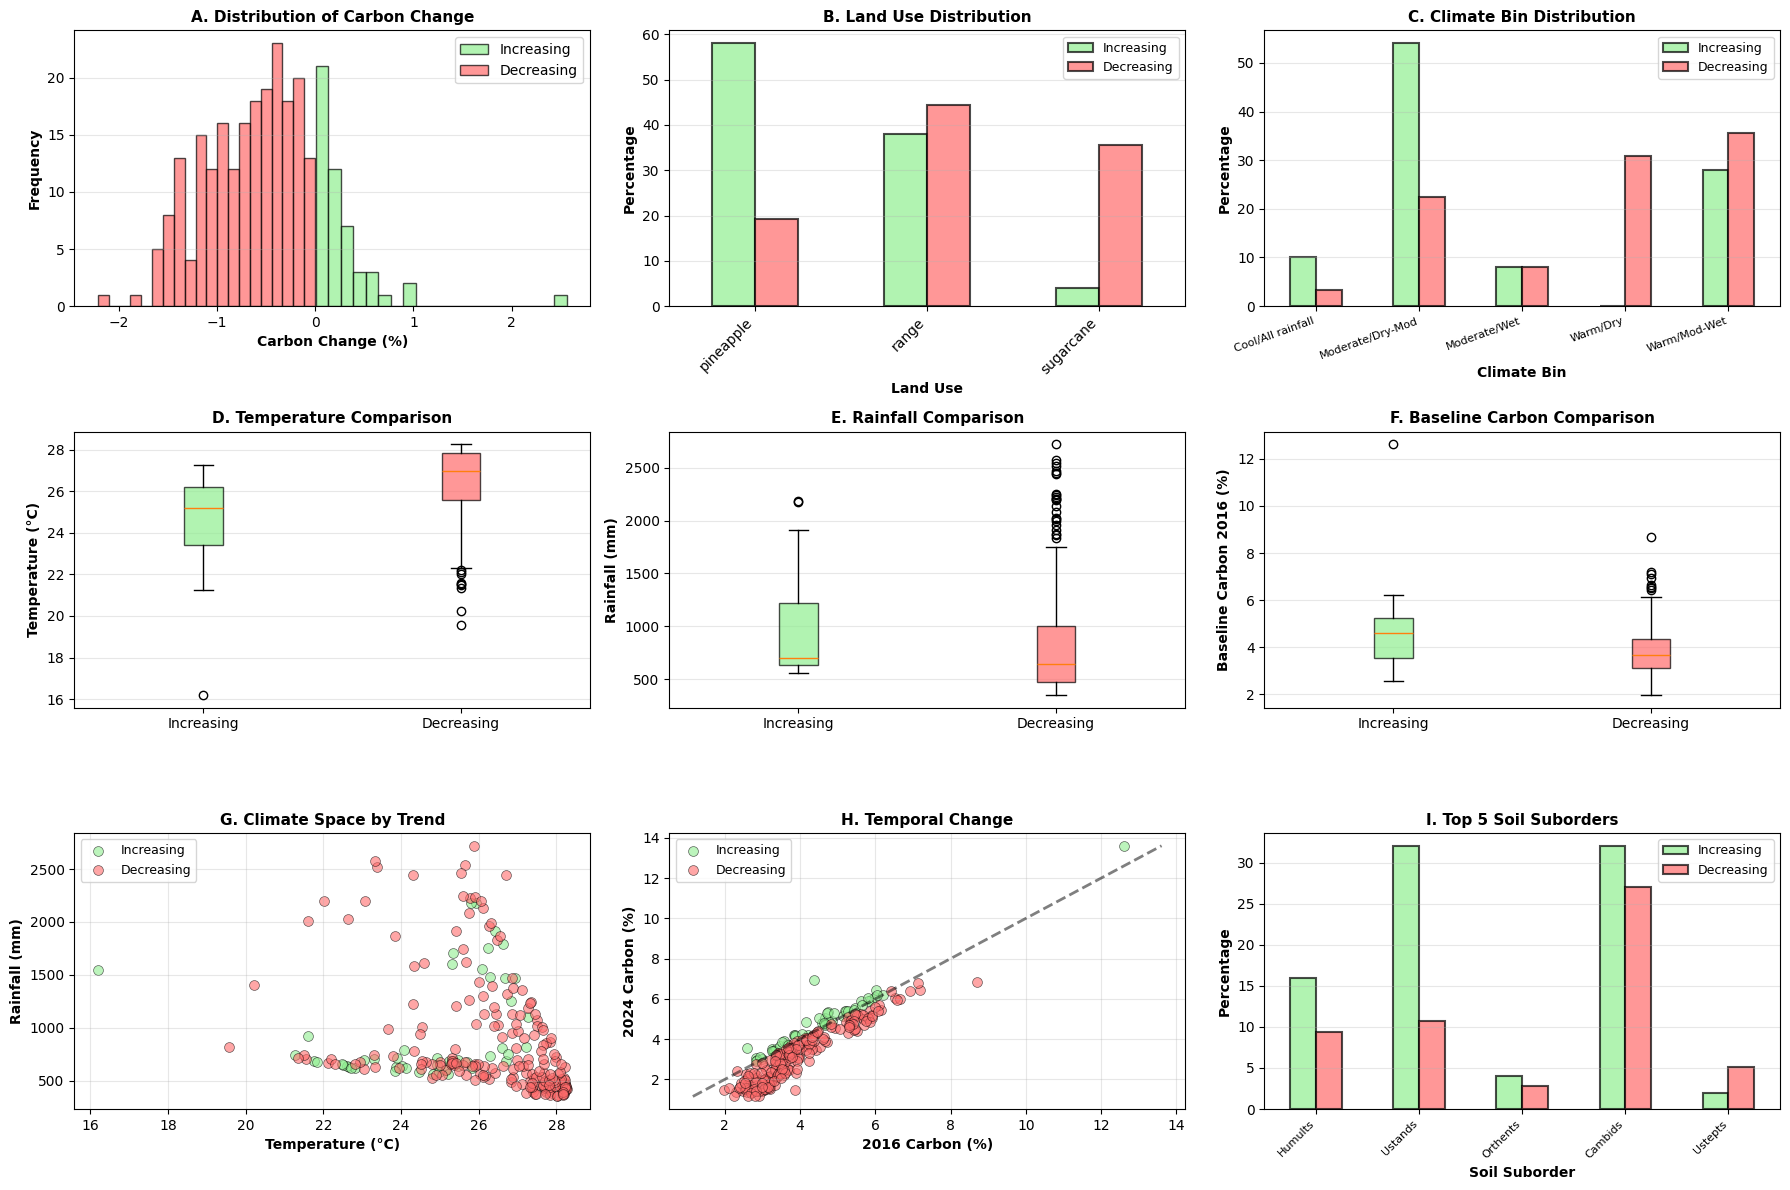

In [78]:
# ============================================================================
# 5. COMPREHENSIVE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(18, 12))

# A. Change distribution
ax1 = plt.subplot(3, 3, 1)
ax1.hist(increasing['carbon_change'], bins=20, alpha=0.7, color='#90EE90',
         edgecolor='black', label='Increasing')
ax1.hist(decreasing['carbon_change'], bins=20, alpha=0.7, color='#FF6B6B',
         edgecolor='black', label='Decreasing')
ax1.set_xlabel('Carbon Change (%)', fontweight='bold', fontsize=10)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=10)
ax1.set_title('A. Distribution of Carbon Change', fontweight='bold', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# B. Land use by trend
ax2 = plt.subplot(3, 3, 2)
landuse_comp = pd.DataFrame({
    'Increasing': inc_landuse / len(increasing) * 100,
    'Decreasing': dec_landuse / len(decreasing) * 100
}).fillna(0)
landuse_comp.plot(kind='bar', ax=ax2, color=['#90EE90', '#FF6B6B'], alpha=0.7,
                  edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Land Use', fontweight='bold', fontsize=10)
ax2.set_ylabel('Percentage', fontweight='bold', fontsize=10)
ax2.set_title('B. Land Use Distribution', fontweight='bold', fontsize=11)
ax2.legend(fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.grid(alpha=0.3, axis='y')

# C. Climate bins by trend
ax3 = plt.subplot(3, 3, 3)
climate_comp = pd.DataFrame({
    'Increasing': inc_climate / len(increasing) * 100,
    'Decreasing': dec_climate / len(decreasing) * 100
}).fillna(0)
climate_comp.plot(kind='bar', ax=ax3, color=['#90EE90', '#FF6B6B'], alpha=0.7,
                  edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Climate Bin', fontweight='bold', fontsize=10)
ax3.set_ylabel('Percentage', fontweight='bold', fontsize=10)
ax3.set_title('C. Climate Bin Distribution', fontweight='bold', fontsize=11)
ax3.legend(fontsize=9)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=20, ha='right', fontsize=8)
ax3.grid(alpha=0.3, axis='y')

# D. Temperature comparison
ax4 = plt.subplot(3, 3, 4)
bp = ax4.boxplot([increasing['tmax_ann_mean_30m'], decreasing['tmax_ann_mean_30m']],
                  labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax4.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=10)
ax4.set_title('D. Temperature Comparison', fontweight='bold', fontsize=11)
ax4.grid(alpha=0.3, axis='y')

# E. Rainfall comparison
ax5 = plt.subplot(3, 3, 5)
bp = ax5.boxplot([increasing['rainfall_ann_mm_30m'], decreasing['rainfall_ann_mm_30m']],
                  labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax5.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=10)
ax5.set_title('E. Rainfall Comparison', fontweight='bold', fontsize=11)
ax5.grid(alpha=0.3, axis='y')

# F. Baseline carbon comparison
ax6 = plt.subplot(3, 3, 6)
bp = ax6.boxplot([increasing['carbon_first_year'], decreasing['carbon_first_year']],
                  labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax6.set_ylabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=10)
ax6.set_title('F. Baseline Carbon Comparison', fontweight='bold', fontsize=11)
ax6.grid(alpha=0.3, axis='y')

# G. Climate space colored by trend
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(increasing['tmax_ann_mean_30m'], increasing['rainfall_ann_mm_30m'],
           c='#90EE90', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Increasing')
ax7.scatter(decreasing['tmax_ann_mean_30m'], decreasing['rainfall_ann_mm_30m'],
           c='#FF6B6B', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Decreasing')
ax7.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=10)
ax7.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=10)
ax7.set_title('G. Climate Space by Trend', fontweight='bold', fontsize=11)
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)

# H. 2016 vs 2024 carbon
ax8 = plt.subplot(3, 3, 8)
ax8.scatter(increasing['carbon_first_year'], increasing['carbon_last_year'],
           c='#90EE90', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Increasing')
ax8.scatter(decreasing['carbon_first_year'], decreasing['carbon_last_year'],
           c='#FF6B6B', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Decreasing')
# Add 1:1 line
min_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].min().min()
max_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].max().max()
ax8.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.5)
ax8.set_xlabel('2016 Carbon (%)', fontweight='bold', fontsize=10)
ax8.set_ylabel('2024 Carbon (%)', fontweight='bold', fontsize=10)
ax8.set_title('H. Temporal Change', fontweight='bold', fontsize=11)
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)

# I. Top soil suborders by trend
ax9 = plt.subplot(3, 3, 9)
top_suborders = suborder_change.head(5).index
suborder_trend_data = []
for sub in top_suborders:
    inc_pct = (increasing['Suborder_list'] == sub).sum() / len(increasing) * 100
    dec_pct = (decreasing['Suborder_list'] == sub).sum() / len(decreasing) * 100
    suborder_trend_data.append({'Suborder': sub[:10], 'Increasing': inc_pct, 'Decreasing': dec_pct})

suborder_df = pd.DataFrame(suborder_trend_data).set_index('Suborder')
suborder_df.plot(kind='bar', ax=ax9, color=['#90EE90', '#FF6B6B'], alpha=0.7,
                 edgecolor='black', linewidth=1.5)
ax9.set_xlabel('Soil Suborder', fontweight='bold', fontsize=10)
ax9.set_ylabel('Percentage', fontweight='bold', fontsize=10)
ax9.set_title('I. Top 5 Soil Suborders', fontweight='bold', fontsize=11)
ax9.legend(fontsize=9)
plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax9.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

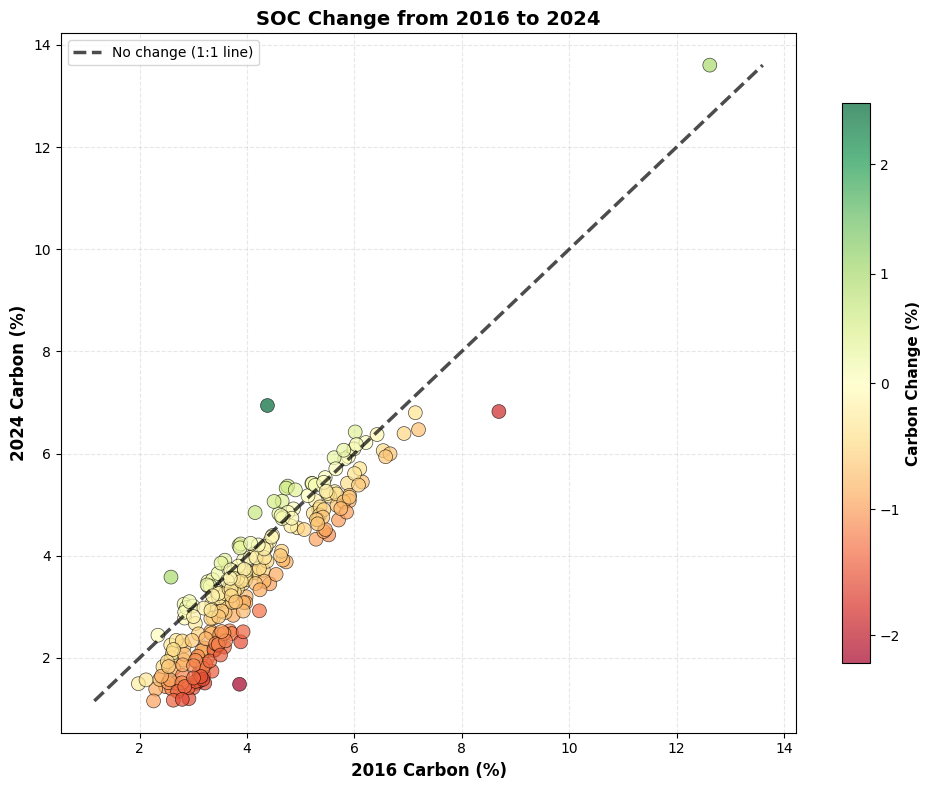

In [87]:
# Standalone version of Plot H: 2016 vs 2024 carbon with magnitude
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter with color representing magnitude of change
scatter = ax.scatter(polygon_summary['carbon_first_year'],
                     polygon_summary['carbon_last_year'],
                     c=polygon_summary['carbon_change'],
                     cmap='RdYlGn',  # Red for decrease, Green for increase
                     norm=TwoSlopeNorm(vmin=polygon_summary['carbon_change'].min(),
                                      vcenter=0,
                                      vmax=polygon_summary['carbon_change'].max()),
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Carbon Change (%)', fontweight='bold', fontsize=11)

# Add 1:1 line
min_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].min().min()
max_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].max().max()
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2.5, alpha=0.7,
         label='No change (1:1 line)')

ax.set_xlabel('2016 Carbon (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('2024 Carbon (%)', fontweight='bold', fontsize=12)
ax.set_title('SOC Change from 2016 to 2024',
             fontweight='bold', fontsize=14)
ax.legend(fontsize=10, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

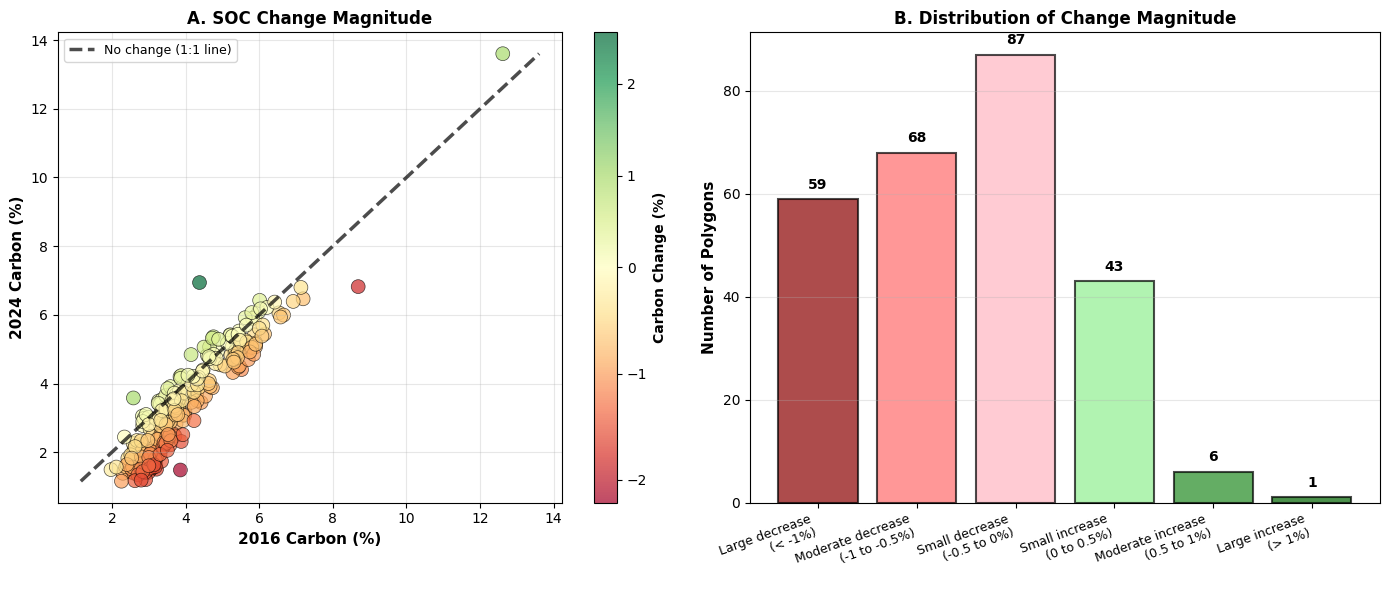

In [92]:
# Change magnitude plotting - Top panels
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# A. 2016 vs 2024 with magnitude (colored)
ax1 = axes[0]
scatter = ax1.scatter(polygon_summary['carbon_first_year'],
                     polygon_summary['carbon_last_year'],
                     c=polygon_summary['carbon_change'],
                     cmap='RdYlGn',
                     norm=TwoSlopeNorm(vmin=polygon_summary['carbon_change'].min(),
                                      vcenter=0,
                                      vmax=polygon_summary['carbon_change'].max()),
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Carbon Change (%)', fontweight='bold', fontsize=10)

min_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].min().min()
max_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].max().max()
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2.5, alpha=0.7,
         label='No change (1:1 line)')

ax1.set_xlabel('2016 Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_ylabel('2024 Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('A. SOC Change Magnitude', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# B. Binned changes - create change magnitude categories
ax2 = axes[1]
polygon_summary['change_category'] = pd.cut(polygon_summary['carbon_change'],
                                            bins=[-np.inf, -1, -0.5, 0, 0.5, 1, np.inf],
                                            labels=['Large decrease\n(< -1%)',
                                                   'Moderate decrease\n(-1 to -0.5%)',
                                                   'Small decrease\n(-0.5 to 0%)',
                                                   'Small increase\n(0 to 0.5%)',
                                                   'Moderate increase\n(0.5 to 1%)',
                                                   'Large increase\n(> 1%)'])

change_cat_counts = polygon_summary['change_category'].value_counts().sort_index()
colors_cat = ['#8B0000', '#FF6B6B', '#FFB6C1', '#90EE90', '#228B22', '#006400']
bars = ax2.bar(range(len(change_cat_counts)), change_cat_counts.values,
               color=colors_cat, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add counts on bars
for i, (cat, count) in enumerate(change_cat_counts.items()):
    ax2.text(i, count + 2, str(count), ha='center', fontweight='bold', fontsize=10)

ax2.set_xticks(range(len(change_cat_counts)))
ax2.set_xticklabels(change_cat_counts.index, rotation=20, ha='right', fontsize=9)
ax2.set_ylabel('Number of Polygons', fontweight='bold', fontsize=11)
ax2.set_title('B. Distribution of Change Magnitude', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

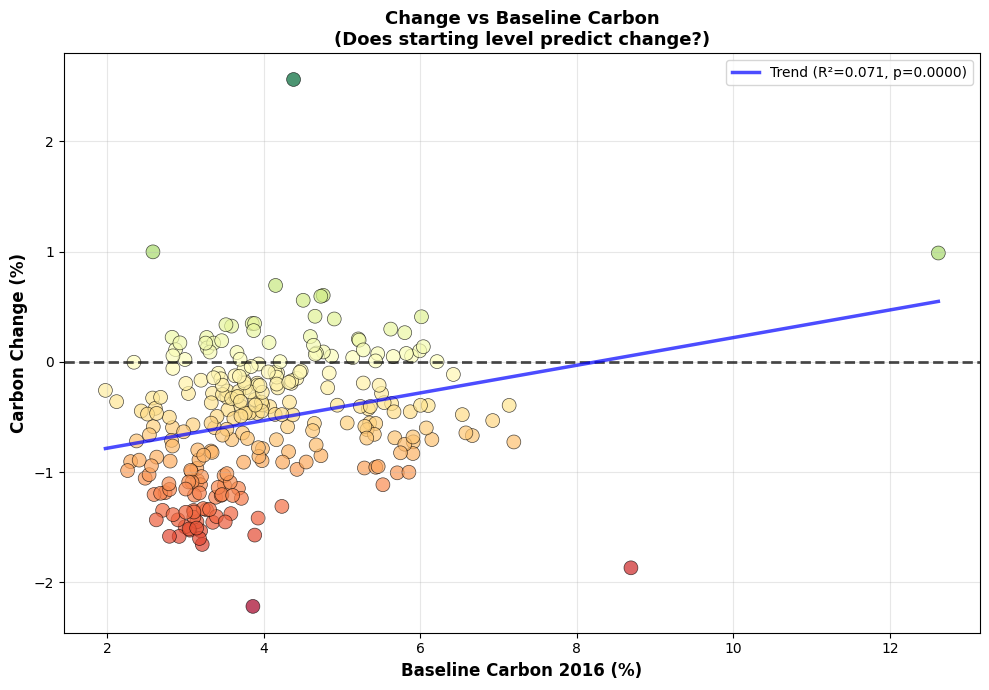


CHANGE MAGNITUDE CATEGORIES

Large decrease
(< -1%): n=59
  Mean change: -1.309%
  Dominant land use: sugarcane
  Dominant climate: Warm/Dry
  Mean temp: 27.5°C
  Mean rainfall: 613 mm

Moderate decrease
(-1 to -0.5%): n=68
  Mean change: -0.746%
  Dominant land use: range
  Dominant climate: Warm/Mod-Wet
  Mean temp: 26.4°C
  Mean rainfall: 1041 mm

Small decrease
(-0.5 to 0%): n=87
  Mean change: -0.286%
  Dominant land use: range
  Dominant climate: Moderate/Dry-Mod
  Mean temp: 25.7°C
  Mean rainfall: 858 mm

Small increase
(0 to 0.5%): n=43
  Mean change: 0.162%
  Dominant land use: pineapple
  Dominant climate: Moderate/Dry-Mod
  Mean temp: 24.8°C
  Mean rainfall: 942 mm

Moderate increase
(0.5 to 1%): n=6
  Mean change: 0.739%
  Dominant land use: pineapple
  Dominant climate: Moderate/Dry-Mod
  Mean temp: 23.4°C
  Mean rainfall: 1003 mm

Large increase
(> 1%): n=1
  Mean change: 2.560%
  Dominant land use: pineapple
  Dominant climate: Moderate/Dry-Mod
  Mean temp: 25.2°C
  Me

In [93]:
# C. Change magnitude by baseline carbon
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(polygon_summary['carbon_first_year'],
                     polygon_summary['carbon_change'],
                     c=polygon_summary['carbon_change'],
                     cmap='RdYlGn',
                     norm=TwoSlopeNorm(vmin=polygon_summary['carbon_change'].min(),
                                      vcenter=0,
                                      vmax=polygon_summary['carbon_change'].max()),
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)

ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Add regression line
slope, intercept, r, p, se = linregress(polygon_summary['carbon_first_year'].dropna(),
                                        polygon_summary['carbon_change'].dropna())
x_range = np.linspace(polygon_summary['carbon_first_year'].min(),
                     polygon_summary['carbon_first_year'].max(), 100)
ax.plot(x_range, slope * x_range + intercept, 'b-', linewidth=2.5, alpha=0.7,
        label=f'Trend (R²={r**2:.3f}, p={p:.4f})')

ax.set_xlabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=12)
ax.set_title('Change vs Baseline Carbon\n(Does starting level predict change?)',
             fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print details about change magnitude categories
print("\n" + "="*80)
print("CHANGE MAGNITUDE CATEGORIES")
print("="*80)
for cat in change_cat_counts.index:
    subset = polygon_summary[polygon_summary['change_category'] == cat]
    print(f"\n{cat}: n={len(subset)}")
    print(f"  Mean change: {subset['carbon_change'].mean():.3f}%")
    print(f"  Dominant land use: {subset['landuse_current'].mode()[0] if len(subset) > 0 else 'N/A'}")
    print(f"  Dominant climate: {subset['climate_description'].mode()[0] if len(subset) > 0 else 'N/A'}")
    print(f"  Mean temp: {subset['tmax_ann_mean_30m'].mean():.1f}°C")
    print(f"  Mean rainfall: {subset['rainfall_ann_mm_30m'].mean():.0f} mm")

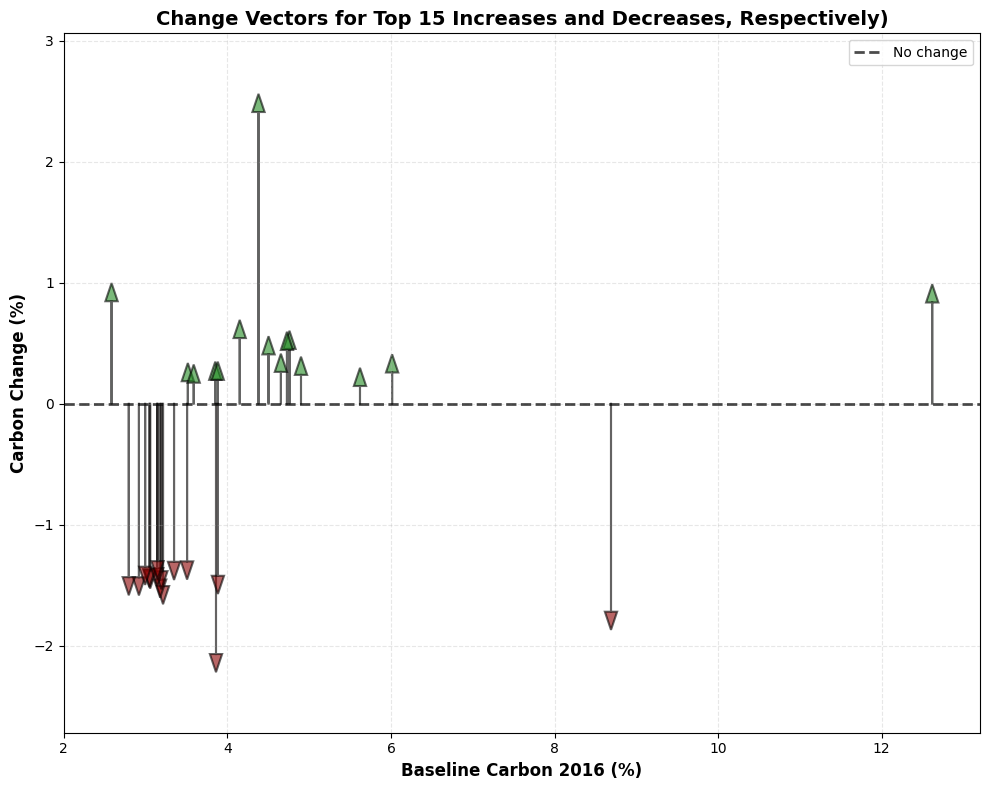


Showing 15 largest increases and 15 largest decreases

Largest increases:
 carbon_first_year  carbon_change landuse_current climate_description
          4.380189       2.560052       pineapple    Moderate/Dry-Mod
          2.583698       0.997136       pineapple    Moderate/Dry-Mod
         12.617339       0.986732           range   Cool/All rainfall
          4.150557       0.692767       pineapple        Warm/Mod-Wet
          4.758848       0.603056       pineapple    Moderate/Dry-Mod
          4.728058       0.594259       pineapple    Moderate/Dry-Mod
          4.503006       0.557907       pineapple    Moderate/Dry-Mod
          4.654142       0.413235       pineapple    Moderate/Dry-Mod
          6.013949       0.408560           range   Cool/All rainfall
          4.899829       0.388522       pineapple   Cool/All rainfall
          3.851468       0.347594           range        Warm/Mod-Wet
          3.882422       0.347456           range        Warm/Mod-Wet
          3.516

In [91]:
# Standalone: Arrows showing direction and magnitude for selected polygons
fig, ax = plt.subplots(figsize=(10, 8))

# Select polygons to show (largest increases and decreases)
n_show = 15
largest_inc = polygon_summary.nlargest(n_show, 'carbon_change')
largest_dec = polygon_summary.nsmallest(n_show, 'carbon_change')
selected = pd.concat([largest_inc, largest_dec])

for idx, row in selected.iterrows():
    color = '#228B22' if row['carbon_change'] > 0 else '#8B0000'
    # Arrow starts at baseline carbon, 0 change
    # Arrow points upward (positive) or downward (negative) by the amount of change
    ax.arrow(row['carbon_first_year'], 0,
             0, row['carbon_change'],
             head_width=0.15, head_length=0.15,
             fc=color, ec='black', alpha=0.6, linewidth=1.5,
             length_includes_head=True)

# Add zero reference line
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='No change')

ax.set_xlabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=12)
ax.set_title(f'Change Vectors for Top {n_show} Increases and Decreases, Respectively)',
             fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.set_ylim(polygon_summary['carbon_change'].min() - 0.5,
            polygon_summary['carbon_change'].max() + 0.5)

plt.tight_layout()
plt.show()

print(f"\nShowing {n_show} largest increases and {n_show} largest decreases")
print(f"\nLargest increases:")
print(largest_inc[['carbon_first_year', 'carbon_change', 'landuse_current', 'climate_description']].to_string(index=False))
print(f"\nLargest decreases:")
print(largest_dec[['carbon_first_year', 'carbon_change', 'landuse_current', 'climate_description']].to_string(index=False))

In [80]:
# ============================================================================
# 6. MULTIVARIATE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MULTIVARIATE PROFILE COMPARISON")
print("="*80)

# Create summary profiles
increasing_profile = {
    'Temperature (°C)': increasing['tmax_ann_mean_30m'].mean(),
    'Rainfall (mm)': increasing['rainfall_ann_mm_30m'].mean(),
    'Baseline Carbon (%)': increasing['carbon_first_year'].mean(),
    '2024 Carbon (%)': increasing['carbon_last_year'].mean(),
    'Carbon Change (%)': increasing['carbon_change'].mean(),
    'Dominant Land Use': increasing['landuse_current'].mode()[0] if len(increasing) > 0 else 'N/A',
    'Dominant Climate': increasing['climate_description'].mode()[0] if len(increasing) > 0 else 'N/A',
    'Dominant Suborder': increasing['Suborder_list'].mode()[0] if len(increasing) > 0 else 'N/A'
}

decreasing_profile = {
    'Temperature (°C)': decreasing['tmax_ann_mean_30m'].mean(),
    'Rainfall (mm)': decreasing['rainfall_ann_mm_30m'].mean(),
    'Baseline Carbon (%)': decreasing['carbon_first_year'].mean(),
    '2024 Carbon (%)': decreasing['carbon_last_year'].mean(),
    'Carbon Change (%)': decreasing['carbon_change'].mean(),
    'Dominant Land Use': decreasing['landuse_current'].mode()[0] if len(decreasing) > 0 else 'N/A',
    'Dominant Climate': decreasing['climate_description'].mode()[0] if len(decreasing) > 0 else 'N/A',
    'Dominant Suborder': decreasing['Suborder_list'].mode()[0] if len(decreasing) > 0 else 'N/A'
}

profile_df = pd.DataFrame({
    'Increasing Polygons': increasing_profile,
    'Decreasing Polygons': decreasing_profile
})

print("\nProfile Comparison:")
print(profile_df)

# Save results
profile_df.to_csv('carbon_trend_profiles.csv')
transition_change.to_csv('carbon_change_by_transition.csv')
suborder_change.to_csv('carbon_change_by_suborder.csv')

print("\n✓ Results saved:")
print("  - carbon_trend_profiles.csv")
print("  - carbon_change_by_transition.csv")
print("  - carbon_change_by_suborder.csv")



MULTIVARIATE PROFILE COMPARISON

Profile Comparison:
                    Increasing Polygons Decreasing Polygons
Temperature (°C)              24.627878           26.417123
Rainfall (mm)                944.351853          848.376055
Baseline Carbon (%)            4.578997            3.925809
2024 Carbon (%)                4.858024            3.193809
Carbon Change (%)              0.279027             -0.7142
Dominant Land Use             pineapple               range
Dominant Climate       Moderate/Dry-Mod        Warm/Mod-Wet
Dominant Suborder               Cambids             Ustolls

✓ Results saved:
  - carbon_trend_profiles.csv
  - carbon_change_by_transition.csv
  - carbon_change_by_suborder.csv


In [103]:
# ============================================================================
# FINAL FIX: REDO SPATIAL JOIN TO GET CORRECT OBJECTID MAPPING
# ============================================================================
print("="*80)
print("REDOING SPATIAL JOIN TO GET CORRECT MAPPING")
print("="*80)

# Step 1: Load the carbon points (without any previous joins)
print("\nStep 1: Loading original carbon data")
print("-"*80)

# Check what we have
print(f"carbon_landuse shape: {carbon_landuse.shape}")
print(f"carbon_landuse columns: {carbon_landuse.columns.tolist()}")

# Get just the essential carbon data and geometry
carbon_points = carbon_landuse[['id', 'lat', 'lon', 'carbon_mean', 'carbon_first_year',
                                'carbon_last_year', 'carbon_change', 'geometry']].copy()
carbon_points = gpd.GeoDataFrame(carbon_points, geometry='geometry', crs=carbon_landuse.crs)

print(f"Carbon points: {len(carbon_points)}")

# Step 2: Load agbaseline
print("\nStep 2: Loading AgBaseline polygons")
print("-"*80)

agbaseline = gpd.read_file('/content/2015_ag_baseline_subregion_landuse.gpkg')
print(f"AgBaseline: {len(agbaseline)} polygons")
print(f"OBJECTID sample: {agbaseline['OBJECTID'].head(10).tolist()}")

# Step 3: Do a fresh spatial join
print("\nStep 3: Performing spatial join")
print("-"*80)

# Make sure CRS match
if carbon_points.crs != agbaseline.crs:
    print(f"Reprojecting carbon points from {carbon_points.crs} to {agbaseline.crs}")
    carbon_points = carbon_points.to_crs(agbaseline.crs)

# Spatial join - this will add agbaseline columns including OBJECTID
carbon_joined = gpd.sjoin(carbon_points, agbaseline[['OBJECTID', 'CropCatego', 'Island', 'geometry']],
                          how='inner', predicate='intersects')

print(f"Joined points: {len(carbon_joined)}")
print(f"Columns after join: {carbon_joined.columns.tolist()}")

# Check if OBJECTID is preserved
if 'OBJECTID' in carbon_joined.columns:
    print(f"✓ OBJECTID preserved in join")
    print(f"  OBJECTID range: {carbon_joined['OBJECTID'].min()} to {carbon_joined['OBJECTID'].max()}")
    print(f"  Unique OBJECTIDs: {carbon_joined['OBJECTID'].nunique()}")

    # Step 4: Aggregate to polygons using ACTUAL OBJECTID
    print("\nStep 4: Aggregating to polygons by OBJECTID")
    print("-"*80)

    polygon_aggregated = carbon_joined.groupby('OBJECTID').agg({
        'carbon_mean': 'mean',
        'carbon_first_year': 'mean',
        'carbon_last_year': 'mean',
        'carbon_change': 'mean',
        'id': 'count'
    }).reset_index()

    polygon_aggregated.columns = ['OBJECTID', 'carbon_mean', 'carbon_2016', 'carbon_2024',
                                  'carbon_change', 'n_points']

    print(f"Aggregated polygons: {len(polygon_aggregated)}")
    print(f"Sample:")
    print(polygon_aggregated.head())

    # Add other attributes from polygon_summary if available
    # We need to create a mapping from old poly_id to OBJECTID

    # Get the mapping: which poly_id corresponds to which OBJECTID
    poly_id_to_objectid = carbon_joined.groupby('OBJECTID').first().reset_index()[['OBJECTID']]
    poly_id_to_objectid['poly_id'] = range(len(poly_id_to_objectid))

    print(f"\nMapping poly_id to OBJECTID:")
    print(poly_id_to_objectid.head())

    # Now merge polygon_summary attributes using this mapping
    # First add OBJECTID to polygon_summary
    polygon_summary_with_obj = polygon_summary.merge(poly_id_to_objectid[['poly_id', 'OBJECTID']],
                                                      on='poly_id', how='left')

    # Check overlap
    print(f"\nPolygon summary with OBJECTID:")
    print(f"  Rows: {len(polygon_summary_with_obj)}")
    print(f"  OBJECTID range: {polygon_summary_with_obj['OBJECTID'].min()} to {polygon_summary_with_obj['OBJECTID'].max()}")
    print(f"  Sample OBJECTIDs: {polygon_summary_with_obj['OBJECTID'].head(10).tolist()}")

    # Step 5: Merge aggregated carbon data with full polygon_summary attributes
    print("\nStep 5: Merging aggregated carbon with polygon attributes")
    print("-"*80)

    # Drop geometry from polygon_summary if exists
    polygon_attrs = polygon_summary_with_obj.drop(columns=['geometry'], errors='ignore')

    # Merge
    full_polygon_data = polygon_aggregated.merge(
        polygon_attrs[['OBJECTID', 'landuse_historic', 'landuse_current', 'transition',
                      'land_use_changed', 'tmax_ann_mean_30m', 'rainfall_ann_mm_30m',
                      'climate_description', 'Suborder_list', 'carbon_trend', 'change_category']],
        on='OBJECTID',
        how='left'
    )

    print(f"Full polygon data: {len(full_polygon_data)}")
    print(f"Columns: {full_polygon_data.columns.tolist()}")

    # Step 6: Merge with agbaseline geometries
    print("\nStep 6: Adding geometries from AgBaseline")
    print("-"*80)

    final_gdf = agbaseline.merge(full_polygon_data, on='OBJECTID', how='inner')

    print(f"Final GeoDataFrame: {len(final_gdf)} features")

    if len(final_gdf) > 0:
        final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry', crs=agbaseline.crs)

        print(f"  CRS: {final_gdf.crs}")
        print(f"  Geometry types: {final_gdf.geometry.type.value_counts().to_dict()}")
        print(f"  Bounds: {final_gdf.total_bounds}")

        # Step 7: Clean up and save
        print("\nStep 7: Saving geopackage")
        print("-"*80)

        # Select essential columns
        cols_to_keep = ['OBJECTID', 'CropCatego', 'Island', 'carbon_mean', 'carbon_2016',
                       'carbon_2024', 'carbon_change', 'n_points', 'landuse_historic',
                       'landuse_current', 'transition', 'land_use_changed',
                       'tmax_ann_mean_30m', 'rainfall_ann_mm_30m', 'climate_description',
                       'Suborder_list', 'carbon_trend', 'change_category', 'geometry']

        export_cols = [col for col in cols_to_keep if col in final_gdf.columns]
        gdf_export = final_gdf[export_cols].copy()

        # Rename for clarity
        gdf_export = gdf_export.rename(columns={
            'tmax_ann_mean_30m': 'temp_C',
            'rainfall_ann_mm_30m': 'rainfall_mm',
            'climate_description': 'climate_bin',
            'Suborder_list': 'soil_suborder'
        })

        # Save
        output_file = '/content/carbon_polygons_WORKING.gpkg'
        gdf_export.to_file(output_file, driver='GPKG', layer='carbon')

        print(f"✓ Saved to: {output_file}")
        print(f"  Features: {len(gdf_export)}")

        # Verify
        verify = gpd.read_file(output_file)
        print(f"\n✓ Verification:")
        print(f"  Features: {len(verify)}")
        print(f"  Geometry types: {verify.geometry.type.value_counts().to_dict()}")
        print(f"  File size: {os.path.getsize(output_file):,} bytes")

        print("\n" + "="*80)
        print("SUCCESS! Download 'carbon_polygons_WORKING.gpkg'")
        print("="*80)

else:
    print("✗ OBJECTID not found in joined data")
    print("Available columns:", carbon_joined.columns.tolist())

REDOING SPATIAL JOIN TO GET CORRECT MAPPING

Step 1: Loading original carbon data
--------------------------------------------------------------------------------
carbon_landuse shape: (274505, 144)
carbon_landuse columns: ['id', 'lat', 'lon', 'lat_lon_id', 'landsat_9_unique_locs_id', 'landsat_9_unique_locs_min_dis', 'landsat_8_unique_locs_id', 'landsat_8_unique_locs_min_dis', 'landsat_7_unique_locs_id', 'landsat_7_unique_locs_min_dis', 'landsat_5_unique_locs_id', 'landsat_5_unique_locs_min_dis', 'terrain_SRTM_unique_locs_id', 'terrain_SRTM_unique_locs_min_dis', 'terrain_aspect_unique_locs_id', 'terrain_aspect_unique_locs_min_dis', 'terraclimate_unique_locs_id', 'terraclimate_unique_locs_min_dis', 'terrain_elevation_unique_locs_id', 'terrain_elevation_unique_locs_min_dis', 'terrain_slope_unique_locs_id', 'terrain_slope_unique_locs_min_dis', 'd_20161217', 'd_20170116', 'd_20170215', 'd_20170317', 'd_20170416', 'd_20170516', 'd_20170615', 'd_20170715', 'd_20170814', 'd_20170913', 'd_2017